# This notebook takes a second dataset and runs it thru the model created with the original dataset. Then it takes that dataset 

### Functions

In [1]:
def find_not_matching(list1, list2):
    ''' Takes two lists and finds any strings that don't match in each of them.
    Returns the list not matching from first list, list not matching from second list, 
    and entire list of all not matching.'''
    
    # Find elements that are in list1 but not in list2
    not_matching_in_list2 = set(list1) - set(list2)

    # Find elements that are in list2 but not in list1
    not_matching_in_list1 = set(list2) - set(list1)

    # Combine both sets of non-matching elements
    all_not_matching = not_matching_in_list1.union(not_matching_in_list2)

    return not_matching_in_list2, not_matching_in_list1, all_not_matching

In [2]:
def string_parsing(list):
    ''' Standardizes parsing of strings. Removes hyphens, replaces spaces with underscores. 
    Strips whitespace from front and end of string. '''
    
    # Variable to return later
    arr = []

    # Loop over all elements. Strip whitespace on left and right, replace hyphen with '', replace spaces with '_'
    for i in range(len(list)):
        temp = list[i]
        if temp is not None and type(temp) is not int:
            temp = temp.lstrip()
            temp = temp.rstrip()
            temp = temp.lower().replace('-', ' ').replace(' ', '_')
        arr.append(temp)

    return arr

In [3]:
def string_parsing_word(word):
    ''' Standardizes parsing of a single strings Removes hyphens, replaces spaces with underscores. 
    Strips whitespace from front and end of string. '''
    
    if word is not None and str(word) != 'nan' and type(word) is not int:
        word = word.lstrip()
        word = word.rstrip()
        word = word.lower().replace('-', ' ').replace(' ', '_')
    
    return word

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
import graphviz
from IPython.display import Image

# Disable pandas warning
pd.options.mode.chained_assignment = None

## Clean original dataset creating consistent naming for diseases and symptoms

In [5]:
df = pd.read_csv('dataset.csv')

symptoms = []

for cols in df.columns:
    if cols != 'Disease':
        symptoms.append(df[cols].unique().tolist())
    
symptom_list = sum(symptoms, [])
unique_symptoms = set(symptom_list)
unique_symptoms = [x for x in unique_symptoms if str(x) != 'nan']
unique_symptoms = string_parsing(unique_symptoms)

cleaned_df = pd.DataFrame(columns=unique_symptoms)
cleaned_df['Disease'] = df['Disease'].copy()

cleaned_df['Disease'] = cleaned_df['Disease'].apply(string_parsing_word)

for index,row in df.iloc[1:].iterrows():
    for col in df.columns[1:]:
        value = string_parsing_word(row[col])
        if(str(value) != 'nan'):
            cleaned_df[value][index] = 1

cleaned_df = cleaned_df.fillna(0)

unique_diseases = cleaned_df['Disease'].unique()

## Clean alt dataset creating consistent naming for diseases and symptoms

In [6]:
df_alt = pd.read_csv('dataset_files\Possible_Alternates\Diseases_Symptoms.csv')

# Drop the treatments and code columns
df_alt_dropped = df_alt.drop(['Treatments', 'Code'], axis=1)

# Clean up diseases column
df_alt_dropped['Disease'] = df_alt_dropped['Name'].copy()
df_alt_dropped = df_alt_dropped.drop('Name', axis=1)

# Get rid of comma seperated values in Symptoms column and break each into its own column
# Determine max number of items in any row
max_items = df_alt_dropped['Symptoms'].str.split(',').apply(len).max()

# Split symptoms into separate columns
split_values = df_alt_dropped['Symptoms'].str.split(',', expand=True)

# Rename columns as symptom_1, symptom_2, ...
column_names = [f'Symptom_{i+1}' for i in range(max_items)]
split_values.columns = column_names

# Combine into another dataframe and drop the old symptoms column
df_alt_split = pd.concat([df_alt_dropped, split_values], axis=1)
df_alt_split = df_alt_split.drop('Symptoms', axis=1)

# Parse all words using same formatting
for cols in df_alt_split.columns:
    df_alt_split[cols] = df_alt_split[cols].apply(string_parsing_word)

# Get unique symptoms
symptoms_alt = []

for cols in df_alt_split.columns:
    if cols != 'Disease':
        symptoms_alt.append(df_alt_split[cols].unique().tolist())
        
symptom_list_alt = sum(symptoms_alt, [])
unique_symptoms_alt = set(symptom_list_alt)
unique_symptoms_alt = [x for x in unique_symptoms_alt if str(x) != 'nan']
unique_symptoms_alt = [x for x in unique_symptoms_alt if str(x) != 'None']
unique_symptoms_alt = string_parsing(unique_symptoms_alt)

cleaned_df_alt = pd.DataFrame(columns=unique_symptoms_alt)
cleaned_df_alt['Disease'] = df_alt_split['Disease'].copy()

for index,row in df_alt_split.iloc[1:].iterrows():
    for col in df_alt_split.columns[1:]:
        value = row[col]
        if((str(value) != 'nan') & (str(value) != 'None')):
            cleaned_df_alt[value][index] = 1

# Update names to match those in og
# Define strings to replace
string_replace = {'type_1_diabetes' : 'diabetes',
                  'type_2_diabetes' : 'diabetes',
                  'urinary_tract_infection_(uti)' : 'urinary_tract_infection',
                  'fungal_infection_of_the_skin' : 'fungal_infection',
                  'osteoarthritis' : 'osteoarthristis',
                  'gastroenteritis_(stomach_flu)' : 'gastroenteritis',
                  'gastroesophageal_reflux_disease_(gerd)' : 'gerd',
                  'dengue_fever' : 'dengue',
                  'abdominal_pain_or_cramps' : 'abdominal_pain',
                  'burning_sensation_during_urination' : 'burning_micturition',
                  'increased_hungerincreased_hunger' : 'increased_appetite',
                  'headache' : 'severe_headache',
                  'joint_and_muscle_pain' : 'muscle_pain',
                  'diarrhea' : 'diarrhoea',
                  'peeling_skin' : 'skin_peeling',
                  'rash' : 'skin_rash',
                  'swollen_veins' : 'swollen_blood_vessels',
                  'swelling' : 'swollen_extremeties',
                  'confusion' : 'altered_sensorium',
                  'nausea_or_vomiting' : 'stomach_pain',
                  'frequent_urination' : 'polyuria',
                  'heartburn' : 'indigestion',
                  'fever' : 'mild_fever',
                  'stiffness' : 'movement_stiffness',
                  'difficulty_breathing' : 'breathlessness',
                  'respiratory_symptoms' : 'congestion'
                 }

# Replace strings in dataframe
cleaned_df_alt = cleaned_df_alt.replace(string_replace)

# Find matching values in og and alt dataframe
cleaned_df_alt = cleaned_df_alt[cleaned_df_alt['Disease'].isin(cleaned_df['Disease'])]

# Find matching column names in og and alt dataframe
common_columns = cleaned_df_alt.columns.intersection(cleaned_df.columns)
remove_columns = cleaned_df_alt.columns.difference(common_columns)

# Update to have only matching column names
cleaned_df_alt = cleaned_df_alt.drop(columns=remove_columns)
cleaned_df_alt = pd.DataFrame({col: cleaned_df_alt[col] for col in common_columns})

# Fill nan with zeroes
cleaned_df_alt = cleaned_df_alt.fillna(0)

unique_diseases_alt = cleaned_df_alt['Disease'].unique()
unique_sym_alt = [col for col in cleaned_df_alt.columns if col != 'Disease']

In [7]:
# Checking matches and mis-matches again
no_match_disease_orig, no_match_disease_alt1, no_match_disease_combo = find_not_matching(cleaned_df['Disease'].unique(), 
                                                                                         cleaned_df_alt['Disease'].unique())

sorted_no_match_disease_orig = sorted(no_match_disease_orig)
sorted_no_match_disease_alt1 = sorted(no_match_disease_alt1)
sorted_no_match_disease_combo = sorted(no_match_disease_combo)

# print("Elements in list1 but not in list2:", sorted_no_match_disease_orig)
# print("\n")
# print("Elements in list2 but not in list1:", sorted_no_match_disease_alt1)
# print("\n")
# print("All non-matching elements:", sorted_no_match_disease_combo)

## Match column names from og dataframe but set all values to zero

In [8]:
# List of column names from og to add
new_columns = ['abnormal_menstruation', 'acidity', 'acute_liver_failure', 'altered_sensorium', 'belly_pain', 'blackheads', 'bladder_discomfort', 
               'blister', 'blood_in_sputum', 'blurred_and_distorted_vision', 'breathlessness', 'brittle_nails', 'burning_micturition', 
               'cold_hands_and_feets', 'coma', 'continuous_feel_of_urine', 'continuous_sneezing', 'cramps', 'diarrhoea', 'dischromic__patches', 
               'distention_of_abdomen', 'drying_and_tingling_lips', 'enlarged_thyroid', 'excessive_hunger', 'extra_marital_contacts', 'family_history', 
               'fast_heart_rate', 'fluid_overload', 'foul_smell_of_urine', 'hip_joint_pain', 'history_of_alcohol_consumption', 'indigestion', 
               'inflammatory_nails', 'internal_itching', 'irregular_sugar_level', 'irritation_in_anus', 'lack_of_concentration', 'lethargy', 
               'loss_of_balance', 'mild_fever', 'movement_stiffness', 'mucoid_sputum', 'nodal_skin_eruptions', 'obesity', 'pain_behind_the_eyes', 
               'pain_in_anal_region', 'painful_walking', 'passage_of_gases', 'patches_in_throat', 'phlegm', 'polyuria', 'prominent_veins_on_calf', 
               'puffy_face_and_eyes', 'pus_filled_pimples', 'receiving_blood_transfusion', 'receiving_unsterile_injections', 'red_sore_around_nose', 
               'red_spots_over_body', 'redness_of_eyes', 'rusty_sputum', 'scurring', 'shivering', 'silver_like_dusting', 'sinus_pressure', 
               'skin_peeling', 'skin_rash', 'small_dents_in_nails', 'spinning_movements', 'spotting__urination', 'stiff_neck', 'stomach_bleeding', 
               'stomach_pain', 'sunken_eyes', 'swelled_lymph_nodes', 'swelling_joints', 'swelling_of_stomach', 'swollen_blood_vessels', 
               'swollen_extremeties', 'swollen_legs', 'throat_irritation', 'toxic_look_(typhos)', 'ulcers_on_tongue', 'unsteadiness', 
               'watering_from_eyes', 'weakness_in_limbs', 'weakness_of_one_body_side', 'yellow_crust_ooze', 'yellow_urine', 'yellowing_of_eyes', 
               'yellowish_skin']

# Add new columns and set every row value to zero
for col in new_columns:
    cleaned_df_alt[col] = 0

# Alphabetize the column names in each dataframe
cleaned_df = cleaned_df[sorted(cleaned_df.columns)]
cleaned_df_alt = cleaned_df_alt[sorted(cleaned_df_alt.columns)]

In [9]:
# Checking matches and mis-matches again
no_match_sym_orig, no_match_sym_alt1, no_match_sym_combo = find_not_matching(unique_symptoms, unique_sym_alt)

sorted_no_match_sym_orig = sorted(no_match_sym_orig)
sorted_no_match_sym_alt1 = sorted(no_match_sym_alt1)
sorted_no_match_sym_combo = sorted(no_match_sym_combo)

# print("Elements in list1 but not in list2:", sorted_no_match_sym_orig)
# print("\n")
# print("Elements in list2 but not in list1:", sorted_no_match_sym_alt1)
# print("\n")
# print("All non-matching elements:", sorted_no_match_sym_combo)

## Create model on og data

In [10]:
# OG data
le = LabelEncoder()
le.fit(unique_diseases)
cleaned_df['encoded_disease'] = le.transform(cleaned_df['Disease'])

C:\Users\jbernitt\AppData\Local\Temp\ipykernel_23576\2827872193.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cleaned_df['encoded_disease'] = le.transform(cleaned_df['Disease'])


In [11]:
X = cleaned_df.drop(['Disease', 'encoded_disease'],axis=1)
y = cleaned_df['encoded_disease']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=10)

In [12]:
decision_tree_model = DecisionTreeClassifier(random_state=10,ccp_alpha=0.001)
decision_tree_model.fit(X_train, y_train)
y_pred = decision_tree_model.predict(X_test)

accuracy = accuracy_score(y_test,y_pred)
print(f'Accuracy of the Decision Tree Classifier: {accuracy*100}%')

Accuracy of the Decision Tree Classifier: 97.15447154471545%


In [13]:
feature_names = X.columns.tolist()
target_names = cleaned_df['Disease'].unique().tolist()
export_graphviz(decision_tree_model, out_file='decision_tree_classifier.dot', 
                feature_names=feature_names, class_names=target_names, filled=True)

In [14]:
with open('decision_tree_classifier.dot') as f:
    dot_graph = f.read()
graph = graphviz.Source(dot_graph)
graph.format = 'png'
graph.render('decision_tree',view=False)

Image(filename='decision_tree.png')

In [15]:
# Run data through logistic regression model
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)
y_clf_pred = clf.predict(X_test)

print(f"Score for Logistic Regression:  {clf.score(X_test, y_test)*100}%")

Score for Logistic Regression:  100.0%


In [54]:
print(f"Confusion Matrix:\n {confusion_matrix(y_test, y_clf_pred)}")

Confusion Matrix:
 [[28  0  0 ...  0  0  0]
 [ 0 30  0 ...  0  0  0]
 [ 0  0 29 ...  0  0  0]
 ...
 [ 0  0  0 ... 22  0  0]
 [ 0  0  0 ...  0 29  0]
 [ 0  0  0 ...  0  0 30]]


## Run predictions on alternate data

In [16]:
# Alt data
cleaned_df_alt['encoded_disease'] = le.transform(cleaned_df_alt['Disease'])

X_alt = cleaned_df_alt.drop(['Disease', 'encoded_disease'],axis=1)
y_alt = cleaned_df_alt['encoded_disease']

# Do prediction on alternate data
y_pred_alt = decision_tree_model.predict(X_alt)

accuracy_alt = accuracy_score(y_alt,y_pred_alt)
print(f'Accuracy of the Decision Tree Classifier: {accuracy_alt*100}%')

Accuracy of the Decision Tree Classifier: 11.76470588235294%


In [17]:
# Run data through logistic regression model
y_clf_pred_alt = clf.predict(X_alt)

print(f"Score for Logistic Regression:  {clf.score(X_alt, y_alt)*100}%")

Score for Logistic Regression:  11.76470588235294%


In [55]:
print(f"Confusion Matrix:\n {confusion_matrix(y_alt, y_clf_pred_alt)}")

Confusion Matrix:
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]]


In [18]:
cleaned_df.to_csv('cleaned_dataset.csv',index=False)
cleaned_df_alt.to_csv('cleaned_alt_dataset.csv',index=False)

## Clean alt dataset creating consistent naming for diseases and symptoms

In [19]:
df_alt2 = pd.read_csv('dataset_files\Possible_Alternates\Diseases_Symptoms.csv')

# Drop the treatments and code columns
df_alt2_dropped = df_alt2.drop(['Treatments', 'Code'], axis=1)

# Clean up diseases column
df_alt2_dropped['Disease'] = df_alt2_dropped['Name'].copy()
df_alt2_dropped = df_alt2_dropped.drop('Name', axis=1)

# Get rid of comma seperated values in Symptoms column and break each into its own column
# Determine max number of items in any row
max_items_alt2 = df_alt2_dropped['Symptoms'].str.split(',').apply(len).max()

# Split symptoms into separate columns
split_values_alt2 = df_alt2_dropped['Symptoms'].str.split(',', expand=True)

# Rename columns as symptom_1, symptom_2, ...
column_names_alt2 = [f'Symptom_{i+1}' for i in range(max_items_alt2)]
split_values_alt2.columns = column_names_alt2

# Combine into another dataframe and drop the old symptoms column
df_alt2_split = pd.concat([df_alt2_dropped, split_values_alt2], axis=1)
df_alt2_split = df_alt2_split.drop('Symptoms', axis=1)

# Parse all words using same formatting
for cols in df_alt2_split.columns:
    df_alt2_split[cols] = df_alt2_split[cols].apply(string_parsing_word)

# Update names to match those in og
# Define strings to replace
string_replace_alt2 = {'type_1_diabetes' : 'diabetes',
                  'type_2_diabetes' : 'diabetes',
                  'urinary_tract_infection_(uti)' : 'urinary_tract_infection',
                  'fungal_infection_of_the_skin' : 'fungal_infection',
                  'osteoarthritis' : 'osteoarthristis',
                  'gastroenteritis_(stomach_flu)' : 'gastroenteritis',
                  'gastroesophageal_reflux_disease_(gerd)' : 'gerd',
                  'dengue_fever' : 'dengue',
                  'abdominal_pain_or_cramps' : 'abdominal_pain',
                  'burning_sensation_during_urination' : 'burning_micturition',
                  'increased_hungerincreased_hunger' : 'increased_appetite',
                  'headache' : 'severe_headache',
                  'joint_and_muscle_pain' : 'muscle_pain',
                  'diarrhea' : 'diarrhoea',
                  'peeling_skin' : 'skin_peeling',
                  'rash' : 'skin_rash',
                  'swollen_veins' : 'swollen_blood_vessels',
                  'swelling' : 'swollen_extremeties',
                  'confusion' : 'altered_sensorium',
                  'nausea_or_vomiting' : 'stomach_pain',
                  'frequent_urination' : 'polyuria',
                  'heartburn' : 'indigestion',
                  'fever' : 'mild_fever',
                  'stiffness' : 'movement_stiffness',
                  'difficulty_breathing' : 'breathlessness',
                  'respiratory_symptoms' : 'congestion'
                 }

# Replace strings in dataframe
df_alt2_split = df_alt2_split.replace(string_replace_alt2)

# Turn unique symptoms into column names
symptoms_alt2 = []

for cols in df_alt2_split.columns:
    if cols != 'Disease':
        symptoms_alt2.append(df_alt2_split[cols].unique().tolist())

symptom_list_alt2 = sum(symptoms_alt2, [])
unique_symptoms_alt2 = set(symptom_list_alt2)
unique_symptoms_alt2 = [x for x in unique_symptoms_alt2 if str(x) != 'nan']
unique_symptoms_alt2 = [x for x in unique_symptoms_alt2 if str(x) != 'None']
unique_symptoms_alt2 = string_parsing(unique_symptoms_alt2)

cleaned_df_alt2 = pd.DataFrame(columns=unique_symptoms_alt2)
cleaned_df_alt2['Disease'] = df_alt2_split['Disease'].copy()

for index,row in df_alt2_split.iloc[1:].iterrows():
    for col in df_alt2_split.columns[1:]:
        value = row[col]
        if((str(value) != 'nan') & (str(value) != 'None')):
            cleaned_df_alt2[value][index] = 1

cleaned_df_alt2 = cleaned_df_alt2.fillna(0)

unique_diseases_alt2 = cleaned_df_alt2['Disease'].unique()

## Clean og dataset creating consistent naming for diseases and symptoms
## Create consistent disease naming between the two dataframes

In [20]:
df_og = pd.read_csv('dataset.csv')

# Parse all words using same formatting
for cols in df_og.columns:
    df_og[cols] = df_og[cols].apply(string_parsing_word)

# Get unique symptoms
symptoms_og = []

for cols in df_og.columns:
    if cols != 'Disease':
        symptoms_og.append(df_og[cols].unique().tolist())
        
symptom_list_og = sum(symptoms_og, [])
unique_symptoms_og = set(symptom_list_og)
unique_symptoms_og = [x for x in unique_symptoms_og if str(x) != 'nan']
unique_symptoms_og = [x for x in unique_symptoms_og if str(x) != 'None']
unique_symptoms_og = string_parsing(unique_symptoms_og)

cleaned_df_og = pd.DataFrame(columns=unique_symptoms_og)
cleaned_df_og['Disease'] = df_og['Disease'].copy()

for index,row in df_og.iloc[1:].iterrows():
    # print(row)
    for col in df_og.columns[1:]:
        value = row[col]
        if((str(value) != 'nan') & (str(value) != 'None')):
            cleaned_df_og[value][index] = 1

# Find matching values in og and alt dataframe
cleaned_df_og = cleaned_df_og[cleaned_df_og['Disease'].isin(cleaned_df_alt2['Disease'])]

# Find matching column names in og and alt dataframe
common_columns_og = cleaned_df_og.columns.intersection(cleaned_df_alt2.columns)
remove_columns_og = cleaned_df_og.columns.difference(common_columns_og)

# Update to have only matching column names
cleaned_df_og = cleaned_df_og.drop(columns=remove_columns_og)
cleaned_df_og = pd.DataFrame({col: cleaned_df_og[col] for col in common_columns_og})

# Fill nan with zeroes
cleaned_df_og = cleaned_df_og.fillna(0)

## Get rid of any disease names in alt that aren't in og just to make model processing time less

In [21]:
# Find matching values in og and alt dataframe
cleaned_df_alt2 = cleaned_df_alt2[cleaned_df_alt2['Disease'].isin(cleaned_df_og['Disease'])]

In [22]:
# Checking matches and mis-matches again
no_match_disease_orig, no_match_disease_alt1, no_match_disease_combo = find_not_matching(cleaned_df_og['Disease'].unique(), 
                                                                                         cleaned_df_alt2['Disease'].unique())

sorted_no_match_disease_orig = sorted(no_match_disease_orig)
sorted_no_match_disease_alt1 = sorted(no_match_disease_alt1)
sorted_no_match_disease_combo = sorted(no_match_disease_combo)

# print("Elements in list1 but not in list2:", sorted_no_match_disease_orig)
# print("\n")
# print("Elements in list2 but not in list1:", sorted_no_match_disease_alt1)
# print("\n")
# print("All non-matching elements:", sorted_no_match_disease_combo)

## Make sure og column names match that of alt and are in the same order

In [23]:
# List of column names from alt to add to og
new_columns = ['abdominal_cramps', 'abdominal_distension', 'abdominal_or_back_pain', 'abdominal_or_flank_pain', 'abdominal_pain_(often_in_the_upper_right_quadrant)', 'abdominal_pain_or_bloating', 'abdominal_pain_or_cramping', 'abdominal_pain_or_discomfort', 'abdominal_pain_or_swelling', 'abdominal_swelling_(ascites)', 'abdominal_swelling_or_pain', 'abdominal_tenderness', 'abnormal_bleeding_or_spotting', 'abnormal_discharge_from_the_genitals', 'abnormal_positioning_of_the_testicle(s)_(higher_in_the_groin_area)', 'abnormal_positioning_of_the_urethral_opening_on_the_underside_of_the_penis', 'abnormal_sweating', 'abnormal_vaginal_bleeding', 'abnormal_vaginal_bleeding_outside_of_the_menstrual_period', 'abscess_formation', 'absence_or_undescended_testicle(s)', 'acid_reflux', 'acidic_taste', 'acne', 'age_related_factors', 'altered_judgment', 'altered_perception_of_reality', 'altered_perception_of_time', 'anal_or_vaginal_discharge', 'and_abnormal_head_positioning', 'and_oily_patches_of_skin', 'and_other_organs', 'and_pain_in_the_hand_and_fingers', 'and_psychiatric_symptoms', 'and_signs_of_fluid_overload', 'and_tenderness_along_a_vein', 'anemia', 'anxiety)_when_attempting_to_stop_or_reduce_use', 'anxiety_or_paranoia_(in_some_individuals)', 'apid_breathing', 'arm', 'avoidance_or_restriction_of_certain_foods_or_entire_food_groups', 'back_or_flank_pain', 'backache', 'bad_breath', 'bad_taste', 'balance_problems', 'bedwetting_(in_children)', 'benign_tumors_in_various_organs', 'black', 'bleeding', 'bleeding_after_menopause', 'bleeding_after_sexual_intercourse', 'bleeding_gums', 'bleeding_tendencies', 'blind_spots', 'blindness', 'blistering', 'bloating', 'blood_in_the_urine', 'blood_in_urine', 'blood_in_urine_or_stool', 'bloodshot_eyes', 'bloody_or_black_stools', 'bloody_stools', 'blurred_distance_vision', 'blurred_or_decreased_vision', 'blurred_or_distorted_central_vision', 'blurred_or_distorted_vision', 'blurred_or_hazy_vision', 'blurred_vision', 'blurred_vision_(if_the_chalazion_affects_the_line_of_sight)', 'blurred_vision_when_focusing_on_near_objects', 'blurry_vision', 'body_aches', 'bone_pain', 'bowel_movement_difficulties', 'bowel_obstruction', 'brain', 'breast_lump', 'breast_pain', 'breast_tenderness', 'brief_muscle_contractions_or_jerks', 'burning', 'challenges_with_social_interaction', 'changes_in_appetite_or_sleep_patterns', 'changes_in_bowel_movements', 'changes_in_bowel_or_bladder_habits', 'changes_in_breast_size_or_shape', 'changes_in_coordination_or_balance', 'changes_in_heart_rate', 'changes_in_sensory_experiences', 'changes_in_skin_color_or_temperature', 'changes_in_skin_temperature', 'changes_in_sleep_and_appetite)', 'changes_in_testicular_size_or_shape', 'changes_in_vision', 'chest_congestion', 'chest_discomfort_or_tightness', 'chest_or_back_pain', 'chest_pain_(sharp_and_stabbing)', 'chest_pain_(sharp_or_dull)', 'chest_pain_or_angina', 'chest_pain_or_discomfort', 'chest_pain_or_discomfort_(angina)', 'chest_pain_or_pressure', 'chest_tightness', 'chest_wall_bruising', 'choking_or_gagging', 'cholecystectomy', 'chronic_back_pain_and_stiffness', 'chronic_constipation', 'chronic_cough', 'chronic_diarrhea', 'chronic_pain', 'clicking_or_popping_sounds_in_the_jaw_joint', 'cloudy_or_bloody_urine', 'cloudy_or_hazy_eyes', 'cloudy_urine', 'clumpy_vaginal_discharge_(resembling_cottage_cheese)', 'cognitive', 'cognitive_decline_or_dementia_like_symptoms', 'cognitive_difficulties', 'cognitive_difficulties_(fibro_fog)', 'cognitive_impairments', 'cognitive_or_developmental_problems', 'color_vision_impairment', 'communication_difficulties', 'compulsive_use_of_opioids', 'continued_use_despite_negative_consequences_(such_as_legal_issues', 'continued_use_despite_negative_consequences_(such_as_relationship_problems', 'corneal_abrasions_or_ulcers', 'cough_with_phlegm_or_pus', 'coughing', 'coughing_or_wheezing', 'coughing_up_blood_or_pink_tinged_sputum', 'cramping', 'cravings_for_alcohol', 'curtain_like_shadow_over_vision', 'curvature_of_the_penis', 'cyanosis_(bluish_discoloration_of_the_skin)', 'dandruff', 'dark_or_empty_areas_in_the_visual_field', 'dark_spots_on_the_teeth', 'daytime_sleepiness', 'decreased_appetite', 'decreased_exercise_tolerance', 'decreased_oxygen_levels', 'decreased_urine_output', 'decreased_vision', 'deformity', 'delayed_wound_healing', 'depends_on_the_specific_cranial_nerve_involved;_symptoms_can_include_vision_changes', 'depressive_episodes', 'developmental_delays', 'developmental_delays_(in_children)', 'difficulty', 'difficulty_bonding_with_the_baby', 'difficulty_breathing_or_shortness_of_breath', 'difficulty_chewing_or_opening_the_mouth', 'difficulty_concentrating', 'difficulty_eating', 'difficulty_emptying_the_bladder', 'difficulty_falling_asleep_or_staying_asleep', 'difficulty_gripping_or_using_the_finger', 'difficulty_hearing_high_pitched_sounds', 'difficulty_in_urination', 'difficulty_maintaining_proper_posture', 'difficulty_moving', 'difficulty_moving_or_turning_the_head', 'difficulty_moving_or_using_the_affected_area', 'difficulty_or_poor_urinary_stream', 'difficulty_resisting_urges', 'difficulty_seeing_objects_up_close', 'difficulty_speaking', 'difficulty_speaking_or_walking)', 'difficulty_straightening_or_bending_the_knee', 'difficulty_swallowing', 'difficulty_swallowing_or_breathing', 'difficulty_swallowing_or_speaking', 'difficulty_walking', 'difficulty_walking_or_moving', 'difficulty_with_foot_and_ankle_movement', 'difficulty_with_forearm_movements', 'dilated_pupils', 'disabling_migraines', 'discharge', 'discharge_from_the_eye', 'discharge_from_the_nose', 'discharge_from_the_wound', 'discomfort', 'discomfort_in_the_pelvic_area', 'discomfort_or_pain', 'discomfort_or_pain_during_intercourse', 'discomfort_or_pain_in_the_neck', 'distinct_facial_features_(small_jaw', 'distorted_body_image', 'distorted_or_irregular_corneal_shape', 'dizziness_or_balance_problems', 'dizziness_or_lightheadedness', 'dizziness_or_vertigo', 'double_vision', 'drainage_of_fluid_or_pus_from_the_ear', 'drainage_of_pus_or_blood', 'drooling', 'drooping_of_the_mouth_or_eyelid', 'drowsiness', 'drug_cravings', 'dry', 'dry_cough', 'dry_eyes', 'dry_mouth', 'dry_mouth_and_eyes', 'dry_or_rough_skin', 'dry_skin', 'dryness_or_excessive_tearing', 'ear_drainage', 'ear_fullness', 'ear_pain', 'ear_pain_(particularly_behind_the_ear)', 'earache', 'early_satiety', 'easy_bleeding_or_bruising', 'easy_bruising', 'easy_bruising_and_bleeding', 'easy_bruising_or_bleeding', 'easy_or_excessive_bruising', 'elevated_cholesterol_levels', 'elevated_eosinophil_count_in_the_blood_or_sputum', 'elevated_intraocular_pressure', 'elevated_intraocular_pressure_without_optic_nerve_damage', 'elevated_levels_of_gamma_globulins_in_the_blood', 'elevated_liver_enzymes', 'emotional_distress', 'emptiness', 'empty_scrotum', 'endoscopic_retrograde_cholangiopancreatography_(ercp)_with_stone_removal', 'enlarged', 'enlarged_abdomen_or_uterus', 'enlarged_head_in_infants', 'enlarged_liver', 'enlarged_spleen', 'enlarged_spleen_or_liver', 'enlarged_thyroid_gland_in_the_neck', 'erectile_dysfunction', 'especially_at_night', 'especially_at_night_or_in_response_to_triggers_such_as_allergens_or_exercise', 'especially_during_physical_activity_or_exertion', 'especially_in_the_morning_or_after_periods_of_inactivity', 'especially_when_walking_or_standing', 'euphoria', 'excessive_bleeding_and_bruising', 'excessive_bleeding_from_minor_cuts_or_abrasions', 'excessive_body_weight', 'excessive_daytime_sleepiness', 'excessive_hair_growth', 'excessive_hair_growth_in_women', 'excessive_menstrual_bleeding', 'excessive_sweating_(beyond_what_is_necessary_for_temperature_regulation)', 'excessive_tearing', 'excessive_thirst', 'excessive_worrying', 'excessively_concentrated_urine', 'extreme_fatigue', 'extreme_weight_loss', 'eye_discharge', 'eye_fatigue', 'eye_movement_abnormalities', 'eye_pain', 'eye_pain_or_discomfort', 'eye_pain_with_eye_movement', 'eye_redness', 'eye_strain', 'eyestrain', 'facial_abnormalities', 'facial_changes', 'facial_numbness', 'facial_pain_or_pressure', 'facial_paralysis', 'facial_weakness', 'facial_weakness_or_paralysis', 'failure_to_pass_meconium_(in_newborns)', 'failure_to_thrive', 'fainting', 'fainting_or_lightheadedness', 'fainting_or_near_fainting_episodes', 'fatigue)', 'fatty_deposits_(xanthomas)_on_the_skin_or_tendons', 'fear_of_gaining_weight', 'fear_of_losing_control', 'feeling_of_heaviness_or_tightness', 'feelings_of_connection_or_disconnection', 'feelings_of_guilt_or_worthlessness', 'feet', 'fever_(in_some_cases)', 'flaky_scalp', 'flaky_skin_with_itching', 'flank_pain', 'flashbacks_(in_some_individuals)', 'flashes_of_light', 'flashing_lights_or_floaters', 'floaters', 'floaters_(dark_spots_or_cobwebs_in_the_vision)', 'floaters_(spots_or_cobweb_like_shapes_in_vision)', 'floaters_in_vision', 'flu_like_symptoms_(fever', 'fluid_drainage_from_the_ear', 'fluid_retention', 'foot_fatigue', 'foot_pain_or_achiness', 'foreign_body_sensation', 'forgetfulness', 'foul_odor_around_the_umbilical_area', 'fractures', 'fragile_bones', 'frequent_crying', 'frequent_episodes_of_stone_formation', 'frequent_infections', 'frequent_nosebleeds', 'frequent_or_constant_dribbling_of_urine', 'frequent_urinary_tract_infections', 'fruity_breath_odor', 'fussiness', 'gait_disturbances', 'gambling', 'gastrointestinal_bleeding', 'gastrointestinal_symptoms', 'general_malaise', 'gonadal_dysgenesis', 'gradual_hearing_loss', 'gradual_loss_of_peripheral_vision', 'gradual_loss_of_vision', 'gradual_vision_loss', 'growth_abnormalities_in_children', 'growth_deficiencies', 'growth_on_the_conjunctiva_(white_part_of_the_eye)', 'hair_loss', 'hair_loss_or_balding', 'hallucinations', 'halos_around_lights', 'head_tilting', 'headaches', 'health_issues)', 'health_problems)', 'health_risks)', 'healthy_food_choices', 'hearing_loss', 'hearing_loss_(gradual_and_progressive)', 'hearing_loss_or_impaired_hearing', 'hearing_loss_or_muffled_hearing_in_the_affected_ear', 'heart_and_digestive_problems', 'heart_attack_(when_a_coronary_artery_becomes_completely_blocked)', 'heart_attacks', 'heart_defects', 'heart_inflammation', 'heart_palpitations', 'heart_palpitations_(rapid_or_irregular_heartbeat)', 'heavy_menstrual_bleeding', 'heavy_or_prolonged_menstrual_periods', 'heel_pain', 'hemangioblastomas_(tumors_in_the_brain', 'high_blood_pressure', 'high_blood_pressure_(in_severe_cases)', 'high_blood_pressure_during_pregnancy', 'high_blood_pressure_without_proteinuria_(preeclampsia)', 'high_blood_sugar_levels_during_pregnancy', 'high_levels_of_cholesterol_in_the_blood', 'hoarseness', 'hormonal_imbalances', 'hormonal_imbalances_(such_as_excessive_production_or_deficiency_of_specific_hormones)', 'hyperactivity', 'hypocalcemia_(low_calcium_levels)', 'impaired_color_vision', 'impaired_coordination', 'impaired_immunity', 'impaired_memory_and_cognition', 'impaired_memory_and_concentration', 'impulsive_behaviors_(e.g.', 'impulsivity', 'inability_to_bear_weight', 'inability_to_completely_empty_the_bladder', 'inability_to_conceive_after_one_year_of_unprotected_intercourse', 'inability_to_control_or_limit_alcohol_consumption', 'inability_to_control_or_reduce_opioid_use', 'inability_to_move_the_elbow', 'inability_to_straighten_the_leg', 'inattention', 'including_hormonal_imbalances', 'including_rash', 'increased_blood_sugar_levels', 'increased_energy', 'increased_energy_and_alertness', 'increased_heart_rate', 'increased_heart_rate_and_blood_pressure', 'increased_hunger', 'increased_ketone_production', 'increased_need_to_urinate', 'increased_red_blood_cell_count', 'increased_risk_of_chronic_conditions', 'increased_sensitivity_to_light', 'increased_sensitivity_to_light_(photophobia)', 'increased_thirst', 'increased_urination_or_urine_changes', 'infertility', 'infertility_or_recurrent_miscarriages_(in_some_cases)', 'inflamed_skin', 'inflammation', 'inflammation_and_pain_in_other_joints_(such_as_hips', 'inflammation_of_blood_vessels_leading_to_various_symptoms_depending_on_the_affected_organs', 'inflammation_of_the_glans_penis_(tip_of_the_penis)', 'inflammation_of_the_surrounding_tissue', 'inguinal_hernia', 'insomnia', 'insomnia)_when_attempting_to_stop_or_reduce_cannabis_use', 'insulin_resistance', 'intellectual_disability', 'intense_burning_pain', 'intense_itching', 'intense_joint_pain', 'intense_urge_to_urinate_followed_by_involuntary_urine_leakage', 'intercourse', 'introspective_thoughts', 'involuntary_movements', 'involuntary_muscle_contractions', 'irregular_heart_rhythms', 'irregular_heartbeat', 'irregular_heartbeat_or_palpitations', 'irregular_or_absent_menstrual_cycles', 'irregular_or_rapid_heartbeat', 'irregular_periods', 'irritability_(in_infants_and_young_children)', 'itching_and_irritation_in_the_vagina_and_vulva', 'itching_and_visible_presence_of_lice_or_nits_(eggs)_in_the_hair', 'itching_around_the_anus_or_vagina', 'itching_or_burning_sensation', 'itchy', 'itchy_bumps', 'itchy_skin', 'itchy_welts_on_the_skin', 'jaundice', 'jaundice_(yellowing_of_the_skin_and_eyes)', 'jaw_or_arm_pain_(in_some_cases)', 'jaw_pain_or_tenderness', 'job_difficulties)', 'joint_swelling', 'kidney_cysts', 'kidney_stones', 'knees)', 'lack_of_interest', 'lack_of_menstrual_periods', 'lasting_for_at_least_two_years', 'latent_stage:_no_symptoms', 'leg_pain', 'legs', 'lightheadedness', 'limited_mobility_or_difficulty_moving_the_arm', 'limited_range_of_motion', 'limited_range_of_motion_in_the_spine', 'liver_or_kidney_damage', 'liver_or_spleen_enlargement', 'localized_inflammation_and_swelling', 'localized_muscle_pain', 'loss_of_bladder_or_bowel_control)', 'loss_of_consciousness', 'loss_of_function', 'loss_of_height_over_time', 'loss_of_interest_or_pleasure_in_activities', 'loss_of_sensation', 'loss_of_sensation_in_the_face_or_other_areas', 'low_blood_pressure', 'low_blood_sodium_levels', 'low_blood_sugar_(hypoglycemia)_symptoms_(e.g.', 'low_set_ears)', 'lower_abdominal_pain_and_discomfort_occurring_around_the_time_of_ovulation', 'lower_back_pain', 'lump', 'lump_or_swelling_in_the_testicles', 'lymph_node_enlargement', 'lymphedema', 'manic_episodes', 'mastoid_bone_protrusion_or_swelling', 'may_appear_in_clusters_or_as_single_lesions', 'may_be_asymptomatic_or_associated_with_other_underlying_conditions', 'may_interfere_with_daily_activities', 'memory_impairment', 'memory_loss_or_cognitive_difficulties', 'memory_problems', 'meningitis', 'menstrual_irregularities', 'mental_confusion', 'metabolic_acidosis', 'mild_discomfort', 'mild_to_moderate_head_pain', 'minerals)', 'mood_changes', 'most_colonic_polyps_do_not_cause_symptoms._some_larger_polyps_or_certain_types_may_cause_rectal_bleeding_or_changes_in_bowel_habits', 'motor', 'muffled_or_blocked_sound', 'muscle_aches', 'muscle_aches_and_stiffness', 'muscle_and_joint_pain', 'muscle_cramps', 'muscle_pain_and_stiffness', 'muscle_stiffness', 'muscle_twitches_or_cramps', 'muscle_weakness_or_fatigue', 'nasal_congestion', 'nausea_and_vomiting', 'neck_mass', 'neck_or_back_pain', 'neck_pain_or_stiffness', 'neglecting_responsibilities', 'neurological_deficits', 'neurological_symptoms', 'neurological_symptoms_(tremors', 'neurological_symptoms_that_cannot_be_explained_by_a_medical_condition_or_injury', 'night_blindness', 'night_sweats', 'nipple_changes', 'nosebleeds', 'numbness', 'numbness_or_tingling', 'numbness_or_tingling_in_fingers_or_around_the_mouth', 'numbness_or_tingling_in_the_hand/arm', 'numbness_or_weakness_in_the_arms_or_legs', 'numbness_or_weakness_in_the_extremities', 'nutrient_deficiencies_(vitamins', 'obsessive_focus_on_"clean"_eating', 'often_affecting_the_arms', 'often_in_the_legs', 'often_in_the_limbs', 'often_on_the_tongue_or_inside_of_the_cheeks', 'optic_neuritis_(vision_loss', 'or_bowel_movements)', 'or_difficulty_speaking', 'or_face', 'or_hopelessness', 'or_inflamed_skin_in_skin_folds_(such_as_armpits_or_groin)', 'or_leg_(typically_on_one_side_of_the_body)', 'or_legs', 'or_numbness_that_radiates_from_the_lower_back_through_the_hips_and_down_the_leg', 'or_other_organs)', 'or_painful_veins_in_the_rectal_area', 'or_paralysis_of_the_limbs', 'organ_dysfunction', 'other', 'other_tumors_or_cysts', 'ovarian_cysts', 'overwhelming_fatigue', 'pain', 'pain_during_erections', 'pain_during_intercourse', 'pain_during_sexual_intercourse', 'pain_during_urination', 'pain_or_discomfort', 'pain_or_discomfort_in_the_tailbone_area', 'pain_or_tenderness_at_the_wound_site', 'pain_or_tenderness_on_the_outer_side_of_the_elbow', 'pain_radiating_from_the_lower_back_to_the_leg', 'pain_when_swallowing_and_speaking', 'pain_with_eye_movement)', 'painful', 'painful_blisters_on_the_lips_or_around_the_mouth', 'painful_blisters_on_the_skin_and_mucous_membranes', 'painful_erection', 'painful_intercourse', 'painful_lump_or_swelling_on_the_eyelid', 'painful_periods', 'painful_sores_or_blisters_in_the_mouth_and_throat', 'painful_ulcers_or_sores_on_the_genital_area', 'painful_urination', 'painless_bleeding_in_the_third_trimester', 'painless_fluid_filled_swelling_in_the_oral_cavity', 'painless_lump_or_swelling', 'painless_swelling', 'pale_skin', 'pale_stools', 'palpable_mass', 'pancreatic_cysts/tumors', 'panic_attacks', 'paranoia', 'particularly_on_the_hands_and_feet', 'patchy_or_generalized_hair_loss', 'pelvic_pain', 'pelvic_pain_(during_menstruation', 'pelvic_pain_or_discomfort', 'pelvic_pain_or_pressure', 'pelvic_pressure_or_heaviness', 'penile_curvature', 'perforation_of_the_digestive_tract', 'peripheral_vision_impairment', 'persistent', 'persistent_consumption_of_non_food_substances', 'persistent_cough_with_thick_mucus', 'persistent_cough_with_yellow_or_green_mucus', 'persistent_depressive_symptoms_(low_mood', 'persistent_feelings_of_sadness', 'persistent_head_pain', 'persistent_hunger', 'persistent_knee_pain', 'persistent_pain_or_discomfort_in_the_vulva', 'persistent_sore_throat', 'personality_changes', 'petechiae_(red_or_purple_spots_on_the_skin)', 'petechial_rash_(small_red_or_purple_spots)', 'pheochromocytomas_(adrenal_gland_tumors)', 'pneumonia', 'poor_appetite', 'poor_coordination', 'poor_depth_perception', 'poor_growth_or_weight_gain', 'poor_weight_gain', 'poor_wound_healing', 'post_nasal_drip', 'postnasal_drip', 'primary_stage:_painless_sores_(chancre)_at_the_site_of_infection', 'productive_cough_with_foul_smelling_or_bloody_sputum', 'progressive_muscle_weakness_and_degeneration', 'prolonged_bleeding_after_injury_or_surgery', 'prolonged_bleeding_from_cuts', 'prolonged_bleeding_from_wounds_or_after_dental_work_or_surgery', 'prolonged_bleeding_or_bruising', 'prolonged_or_excessive_bleeding_from_cuts_or_injuries', 'prolonged_or_heavy_bleeding', 'proteinuria', 'psychosis_(in_severe_cases)', 'pus_formation', 'pus_or_drainage_from_the_wound', 'raised', 'rapid_breathing', 'rapid_heart_rate', 'rapid_heartbeat', 'rapid_or_irregular_heartbeats', 'rapid_or_shallow_breathing', 'rapid_pulse', 'rash_(red', 'rash_at_birth', 'rash_or_soreness_in_the_affected_area', 'raw', 'rawness', "raynaud's_phenomenon", 'rectal_bleeding', 'recurrent', 'recurrent_ear_infections', 'recurrent_episodes_of_binge_eating_followed_by_purging_behaviors', 'recurrent_episodes_of_binge_eating_without_compensatory_behaviors', 'recurrent_episodes_of_wheezing', 'recurrent_eye_infections', 'recurrent_lung_infections', 'red', 'red_lump_or_swelling_on_the_eyelid', 'red_rash_caused_by_contact_with_irritants_or_allergens', 'redness', 'redness_and_swelling_of_the_vulva', 'redness_or_irritation_of_the_eye', 'reduced_anxiety', 'reduced_hearing_sensitivity', 'reduced_range_of_motion', 'relaxation', 'renal_cell_carcinomas_(kidney_tumors)', 'repeated_regurgitation_and_re_chewing_of_food', 'respiratory_depression', 'respiratory_distress', 'restless_sleep', 'restricted_interests_or_repetitive_behaviors', 'restricted_range_of_motion', 'retinal_angiomas_(abnormal_blood_vessel_growth_in_the_retina)', 'rib_fractures_(associated_injuries)', 'risk_of_heart_attack_or_stroke', 'rough', 'rough_growths_on_the_skin_or_mucous_membranes', 'rounded_face', 'salty_tasting_skin', 'sandpaper_like)', 'scaly_patches_on_the_skin', 'secondary_stage:_skin_rash', 'sedation', 'seizures', 'sensation_of_a_foreign_object_stuck_in_the_throat', 'sensitivity_to_cold', 'sensitivity_to_light', 'sensitivity_to_light_(photophobia)', 'sensitivity_to_light_and_sound', 'sensitivity_to_light_or_noise', 'severe_abdominal_or_back_pain', 'severe_abdominal_pain', 'severe_and_chronic_pain', 'severe_and_persistent_pain', 'severe_eye_pain', 'severe_headache', 'severe_headaches', 'severe_kidney_damage', 'severe_nausea_and_vomiting_during_pregnancy', 'severe_neck_pain', 'severe_pain', 'severe_pain_in_the_side_or_back', 'severe_sore_throat', 'severe_swelling_of_the_floor_of_the_mouth', 'severe_upper_abdominal_pain', 'shaking', 'sharp', 'sharp_or_aching_pain_in_the_lower_abdomen_or_groin', 'sharp_or_stabbing_pain', 'sharp_pain', 'shooting_or_burning_pain', 'shooting_pain_along_the_affected_nerve', 'short_stature', 'shortness_of_breath', 'shoulder_pain', 'shoulder_pain_(if_the_fallopian_tube_ruptures)', 'shoulder_stiffness', 'shoulders', 'significant_weight_loss_or_failure_to_gain_weight', 'skin_abnormalities', 'skin_changes', 'skin_discoloration', 'skin_rashes', 'skin_sores', 'skipped_or_extra_heartbeats', 'sleep_disturbances', 'slow_healing_of_wounds', 'slow_heart_rate', 'slowed_breathing', 'slowness_of_movement', 'small', 'small_blisters_or_bumps', 'small_lump_or_swelling_in_the_vaginal_wall', 'smaller_or_underdeveloped_testicle(s)', 'sneezing', 'soles', 'sore_throat', 'sore_tongue', 'speech_sounds_muffled_or_unclear', 'sphincterotomy', 'spinal_cord', 'spontaneous_bleeding_in_joints_or_muscles', 'spotting_or_light_bleeding_between_periods', 'spraying_of_urine', 'squinting', 'stealing)', 'stinging', 'strokes', 'strong_desire_or_cravings_for_opioids', 'such_as_diarrhea_or_constipation.', 'such_as_paralysis', 'sudden', 'sudden_and_severe_abdominal_or_pelvic_pain_on_one_side', 'sudden_loss_of_muscle_tone_(cataplexy)', 'sudden_numbness_or_weakness_of_the_face', 'sudden_onset_of_neurological_symptoms_that_resolve_within_24_hours', 'sudden_vision_loss', 'sunburn_like_rash', 'surgical_site_pain', 'sweating)', 'sweating)_when_attempting_to_stop_or_reduce_alcohol_use', 'swelling_and_redness_of_the_ear_or_the_area_behind_the_ear', 'swelling_and_tenderness_of_the_cartilage_connecting_the_ribs_to_the_breastbone', 'swelling_in_arms_or_legs', 'swelling_in_the_abdomen', 'swelling_in_the_ankles', 'swelling_in_the_legs_and_ankles', 'swelling_of_the_legs_or_ankles', 'swelling_of_the_limbs', 'swelling_of_the_scrotum', 'swelling_or_visible_protrusion', 'swollen', 'swollen_and_bleeding_gums', 'swollen_and_tender_abdomen', 'swollen_blood_vessels_in_the_esophagus', 'swollen_eyelids', 'swollen_glands', 'swollen_legs_or_ankles', 'swollen_lymph_nodes', 'swollen_lymph_nodes_in_the_groin', 'swollen_salivary_glands_(usually_parotid)', 'swollen_tonsils', 'symptoms_that_do_not_meet_the_full_criteria_for_a_specific_eating_disorder', 'tarry_stools', 'tender_gums', 'tenderness', 'tenderness_or_pain_when_touching_the_area', 'tenderness_or_swelling_in_affected_areas', 'tenderness_or_swelling_over_the_ribcage', 'tension_in_neck_and_shoulders', 'tertiary_stage:_severe_complications_affecting_the_heart', 'tetany_(muscle_spasms)', 'that_cannot_be_scraped_off', 'thick', 'thick_nasal_discharge', 'thickening_of_the_skin', 'thoughts_of_self_harm_or_harming_the_baby', 'throbbing_headache', 'tightness_or_pressure_sensation_on_both_sides_of_head', 'tingling', 'tingling_in_limbs', 'tingling_or_numbness', 'tingling_or_numbness_in_extremities_in_severe_cases', 'tingling_or_numbness_in_the_hands_and_feet', 'tinnitus', 'tinnitus_(ringing_in_the_ears)', 'tolerance_to_alcohol', 'tolerance_to_opioids', 'tooth_sensitivity', 'toothache', 'transverse_myelitis_(weakness', 'trembling', 'tremors', 'tremors)_when_attempting_to_stop_or_reduce_benzodiazepine_use', 'tremors)_when_attempting_to_stop_or_reduce_use', 'trigger_points', 'trouble_concentrating_or_making_decisions', 'trouble_speaking_or_understanding', 'tunnel_vision', 'typically_in_specific_areas_(such_as_palms', 'typically_painless', 'uncomfortable_sensation_in_the_legs', 'underarms)', 'uneven_curvature_of_cornea', 'unexplained_weight_loss', 'unintentional_urine_leakage_during_physical_activity', 'unintentional_weight_loss', 'unpredictable_bleeding_episodes', 'unrefreshing_sleep', 'urge_to_move_legs_for_relief', 'urgency', 'urinary_frequency', 'urinary_frequency_or_urgency', 'urinary_incontinence', 'urinary_tract_infections', 'urinary_urgency_or_frequency', 'usually_in_sun_exposed_areas', 'usually_in_the_evening_or_at_night', 'usually_near_the_cornea', 'usually_on_the_lower_lip_or_floor_of_the_mouth', 'usually_on_the_upper_eyelid', 'vaginal_bleeding', 'vaginal_burning', 'vaginal_dryness', 'varies_depending_on_the_underlying_cause', 'various_symptoms_depending_on_the_specific_disorder', 'vertigo', 'visible_bulge_or_swelling', 'visible_deformity', 'visible_lice_or_nits_in_the_affected_area', 'visible_peristalsis', 'visible_pits_or_holes_in_the_teeth', 'visible_veins', 'vision_changes', 'vision_loss', 'vision_loss_or_blurry_vision', 'vision_problems', 'vision_problems_(such_as_blurred_vision_or_loss_of_peripheral_vision)', 'visual_field_defects', 'visual_field_loss', 'visual_or_auditory_hallucinations', 'vocal_changes', 'vocal_fatigue', 'voice_changes', 'vomiting_blood', 'warmth', 'watery_discharge', 'weak_grip_strength', 'weak_urine_stream', 'weakened_immune_system', 'weakness', 'weakness_or_loss_of_strength', 'weakness_or_numbness', 'webbed_neck', 'weight_changes', 'weight_gain_or_loss', 'wheezing', 'white', 'white_patches_or_plaques_in_the_mouth', 'widespread_musculoskeletal_pain', 'with_associated_swelling', 'withdrawal_symptoms_(such_as_irritability', 'withdrawal_symptoms_(such_as_nausea', 'withdrawal_symptoms_(such_as_rebound_anxiety', 'withdrawal_symptoms_(such_as_tremors', 'worsens_with_deep_breaths_or_lying_down', 'yellowing_of_the_skin_and_eyes', "yellowish_or_white_growth_on_the_conjunctiva_(eye's_surface)"]

# Add new columns and set every row value to zero
for col in new_columns:
    cleaned_df_og[col] = 0

# Alphabetize the column names in each dataframe
cleaned_df_og = cleaned_df_og[sorted(cleaned_df_og.columns)]
cleaned_df_alt2 = cleaned_df_alt2[sorted(cleaned_df_alt2.columns)]

C:\Users\jbernitt\AppData\Local\Temp\ipykernel_23576\1113907206.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cleaned_df_og[col] = 0
C:\Users\jbernitt\AppData\Local\Temp\ipykernel_23576\1113907206.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cleaned_df_og[col] = 0
C:\Users\jbernitt\AppData\Local\Temp\ipykernel_23576\1113907206.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once us

In [24]:
# Checking matches and mis-matches again

unique_sym_og = [col for col in cleaned_df_og.columns if col != 'Disease']
unique_sym_alt2 = [col for col in cleaned_df_alt2.columns if col != 'Disease']

no_match_sym_orig, no_match_sym_alt1, no_match_sym_combo = find_not_matching(unique_sym_og, unique_sym_alt2)

sorted_no_match_sym_orig = sorted(no_match_sym_orig)
sorted_no_match_sym_alt1 = sorted(no_match_sym_alt1)
sorted_no_match_sym_combo = sorted(no_match_sym_combo)

# print("Elements in list1 but not in list2:", sorted_no_match_sym_orig)
# print("\n")
# print("Elements in list2 but not in list1:", sorted_no_match_sym_alt1)
# print("\n")
# print("All non-matching elements:", sorted_no_match_sym_combo)

## Create model on alt data (test data will come from og dataset since each disease occurs only once in this dataset)

C:\Users\jbernitt\AppData\Local\Temp\ipykernel_23576\1143538153.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cleaned_df_alt2['encoded_disease'] = le_alt2.transform(cleaned_df_alt2['Disease'])


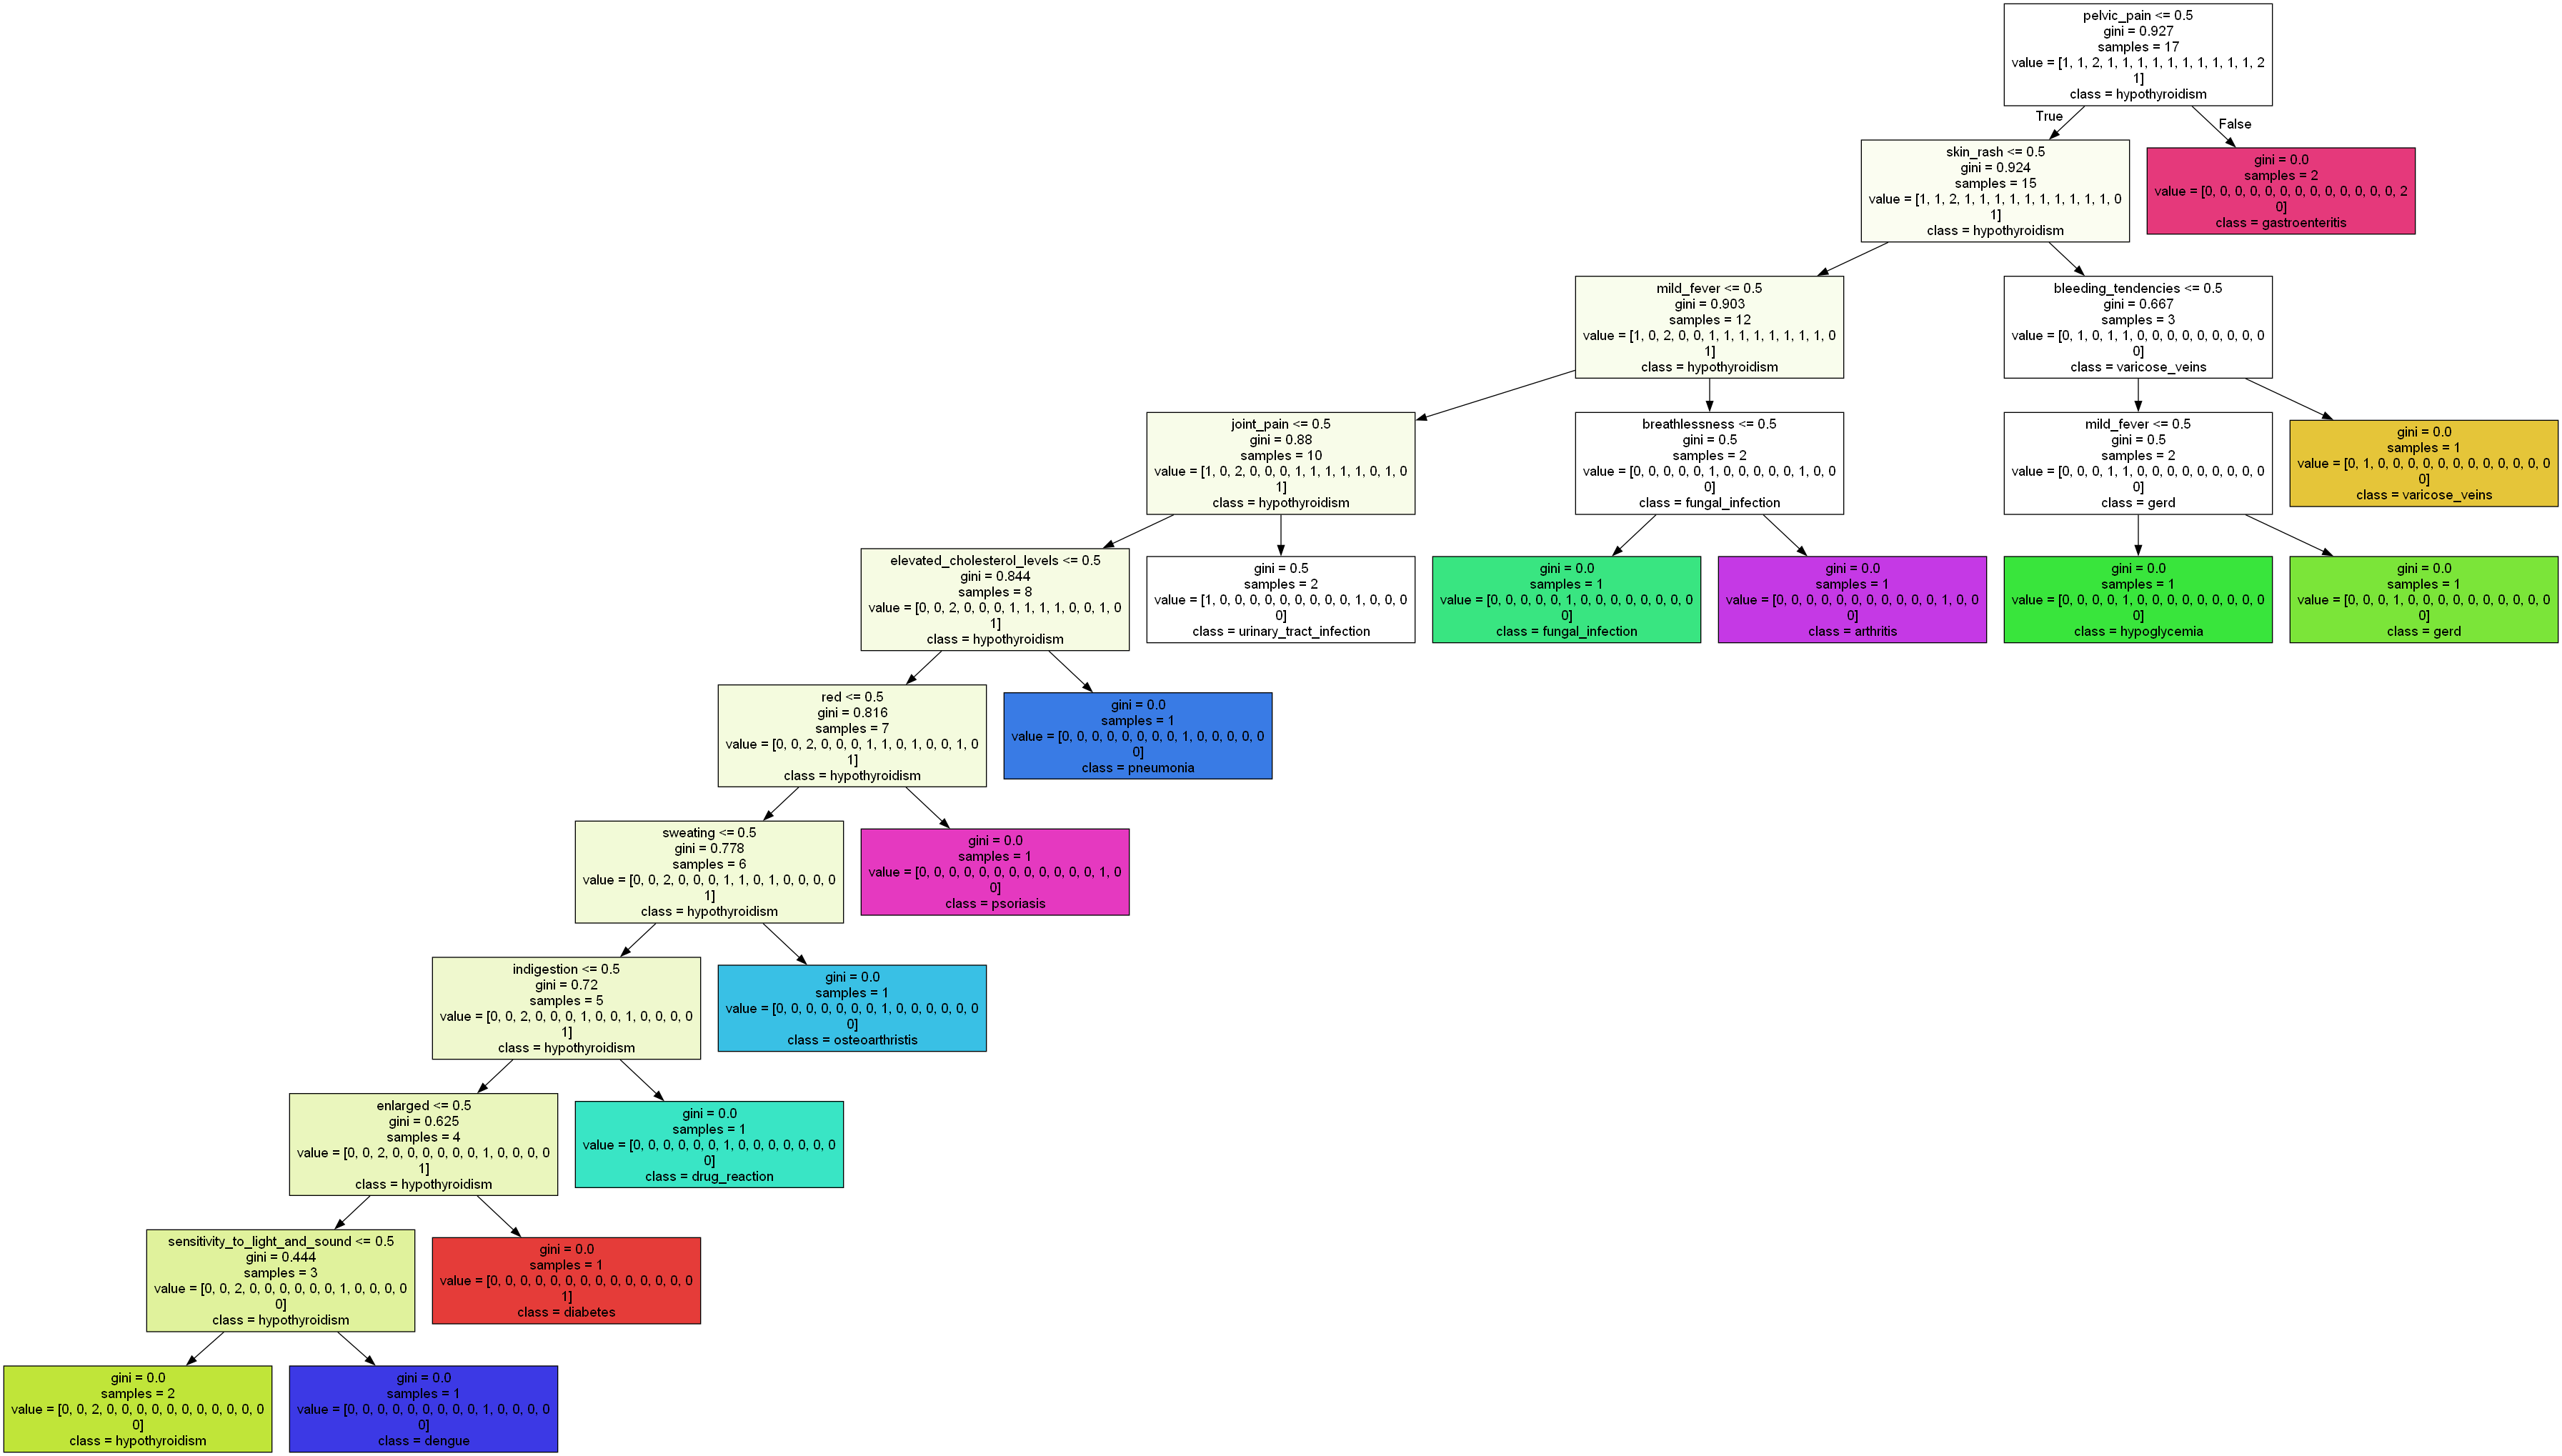

In [25]:
# Alt data
le_alt2 = LabelEncoder()
le_alt2.fit(cleaned_df_alt2['Disease'].unique())
cleaned_df_alt2['encoded_disease'] = le_alt2.transform(cleaned_df_alt2['Disease'])

X_alt2 = cleaned_df_alt2.drop(['Disease', 'encoded_disease'],axis=1)
y_alt2 = cleaned_df_alt2['encoded_disease']
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=10)

decision_tree_model_alt2 = DecisionTreeClassifier(random_state=10,ccp_alpha=0.001)
decision_tree_model_alt2.fit(X_alt2, y_alt2)

feature_names_alt2 = X_alt2.columns.tolist()
target_names_alt2 = cleaned_df_alt2['Disease'].unique().tolist()
export_graphviz(decision_tree_model_alt2, out_file='decision_tree_classifier_alt2.dot', 
                feature_names=feature_names_alt2, class_names=target_names_alt2, filled=True)

with open('decision_tree_classifier_alt2.dot') as f:
    dot_graph_alt2 = f.read()
graph_alt2 = graphviz.Source(dot_graph_alt2)
graph_alt2.format = 'png'
graph_alt2.render('decision_tree_alt2',view=False)

Image(filename='decision_tree_alt2.png')

In [26]:
# Alt data
cleaned_df_og['encoded_disease'] = le_alt2.transform(cleaned_df_og['Disease'])

X_og = cleaned_df_og.drop(['Disease', 'encoded_disease'],axis=1)
y_og = cleaned_df_og['encoded_disease']

# Do prediction on alternate data
y_pred_og = decision_tree_model_alt2.predict(X_og)

accuracy_og = accuracy_score(y_og,y_pred_og)
print(f'Accuracy of the Decision Tree Classifier: {accuracy_og*100}%')

Accuracy of the Decision Tree Classifier: 18.944444444444443%


C:\Users\jbernitt\AppData\Local\Temp\ipykernel_23576\1317548481.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cleaned_df_og['encoded_disease'] = le_alt2.transform(cleaned_df_og['Disease'])


In [27]:
# Run data through logistic regression model
clf_alt2 = LogisticRegression(random_state=42)
clf_alt2.fit(X_alt2, y_alt2)
y_clf_pred_og = clf_alt2.predict(X_og)

print(f"Score for Logistic Regression:  {clf_alt2.score(X_og, y_og)*100}%")

Score for Logistic Regression:  35.94444444444444%


In [56]:
print(f"Confusion Matrix:\n {confusion_matrix(y_og, y_clf_pred_og)}")

Confusion Matrix:
 [[  0   0 120   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 102  18   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 120   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 102   0   0   0   0   0   0   0   0  18   0]
 [  0   0  25   0  95   0   0   0   0   0   0   0   0   0   0]
 [  0   0  18   0   0 102   0   0   0   0   0   0   0   0   0]
 [  0   0   6   0   0   0   6   0   0   0   0 108   0   0   0]
 [  0   0 114   0   0   6   0   0   0   0   0   0   0   0   0]
 [  0   0 120   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   6   0   0   0 114   0   0   0   0   0   0   0   0]
 [  0   0 120   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  12   0   0   0   0   0   0   0   0 108   0   0   0]
 [  0   0  12   0 108   0   0   0   0   0   0   0   0   0   0]
 [  0   0  12   0   0   0   0   0   0   0   0   0   0 108   0]
 [  0   0 114   0   0   0   0   0   0   0   0   0   0   0   6]]


In [28]:
cleaned_df_og.to_csv('cleaned_dataset_og.csv',index=False)
cleaned_df_alt2.to_csv('cleaned_alt2_dataset.csv',index=False)

## Test og trained model against a second dataset

In [29]:
# Test on second alternate file
df_alt_vbd = pd.read_csv(r'dataset_files\Possible_Alternates\Vector_Borne_Disease_Prediction\trainn.csv')

# Clean up diseases column
df_alt_vbd['Disease'] = df_alt_vbd['prognosis'].copy()
df_alt_vbd = df_alt_vbd.drop('prognosis', axis=1)

# Parse all words using same formatting
df_alt_vbd['Disease'] = df_alt_vbd['Disease'].apply(string_parsing_word)
df_alt_vbd['Disease'].head()

# Drop any disease that isn't dengue or malaria since those are the two matches in these datasets
mask = (df_alt_vbd['Disease'] != 'dengue') & (df_alt_vbd['Disease'] != 'malaria')
df_alt_vbd_filt = df_alt_vbd[~mask]

for cols in df_alt_vbd_filt.columns:
    df_alt_vbd_filt[cols] = df_alt_vbd_filt[cols].apply(string_parsing_word)

# Update names to match those in og
# Define strings to replace
string_replace = {'yellow_skin' : 'yellowish_skin',
                  'yellow_eyes' : 'yellowing_of_eyes',
                  'confusion' : 'altered_sensorium',
                  'diarrhea' : 'diarrhoea',
                  'diziness' : 'dizziness',
                  'itchiness' : 'itching',
                  'red_eyes' : 'redness_of_eyes',
                  'urination_loss' : 'spotting__urination',
                  'speech_problem' : 'slurred_speech',
                  'rash' : 'skin_rash',
                  'lips_irritation' : 'drying_and_tingling_lips',
                  'breathing_restriction' : 'breathlessness',
                  'lymph_swells' : 'swelled_lymph_nodes',
                  'ulcers' : 'ulcers_on_tongue',
                  'facial_distortion' : 'puffy_face_and_eyes',
                  'skin_lesions' : 'nodal_skin_eruptions',
                  'finger_inflammation' : 'inflammatory_nails',
                  'ascites' : 'distention_of_abdomen',
                  'cocacola_urine' : 'dark_urine',
                  'hyperpyrexia' : 'high_fever',
                  'hypoglycemia' : 'irregular_sugar_level',
                  'orbital_pain' : 'pain_behind_the_eyes',
                  'swelling' : 'swollen_extremeties',
                  'gastro_bleeding' : 'stomach_bleeding',
                  'rigor' : 'movement_stiffness',
                  'digestion_trouble' : 'indigestion',
                  'weakness' : 'muscle_weakness'
                 }

# Replace strings in dataframe
df_alt_vbd_filt.rename(columns=string_replace, inplace=True)

# Find matching column names in og and alt dataframe
common_columns_alt_vbd = df_alt_vbd_filt.columns.intersection(cleaned_df.columns)
remove_columns_alt_vbd = df_alt_vbd_filt.columns.difference(common_columns_alt_vbd)

# Update to have only matching column names
df_alt_vbd_filt = df_alt_vbd_filt.drop(columns=remove_columns_alt_vbd)

In [30]:
# symptoms_alt_vbd = [col for col in df_alt_vbd_filt.columns if col != 'Disease']
# unique_symptoms = [col for col in cleaned_df.columns if col != 'Disease']

# # Checking matches and mis-matches again
# no_match_sym_orig_vbd, no_match_sym_alt_vbd, no_match_sym_combo_vbd = find_not_matching(unique_symptoms, symptoms_alt_vbd)

# sorted_no_match_sym_orig_vbd = sorted(no_match_sym_orig_vbd)
# sorted_no_match_sym_alt_vbd = sorted(no_match_sym_alt_vbd)
# sorted_no_match_sym_combo_vbd = sorted(no_match_sym_combo_vbd)

# print("Elements in list1 but not in list2:", sorted_no_match_sym_orig_vbd)
# print("\n")
# print("Elements in list2 but not in list1:", sorted_no_match_sym_alt_vbd)
# print("\n")
# print("All non-matching elements:", sorted_no_match_sym_combo_vbd)

In [31]:
# List of column names from og to add
new_columns = ['abnormal_menstruation', 'acidity', 'acute_liver_failure', 'anxiety', 'belly_pain', 'blackheads', 'bladder_discomfort', 'blister', 
               'blood_in_sputum', 'bloody_stool', 'blurred_and_distorted_vision', 'brittle_nails', 'bruising', 'burning_micturition', 'chest_pain', 
               'cold_hands_and_feets', 'congestion', 'constipation', 'continuous_feel_of_urine', 'continuous_sneezing', 'cough', 'cramps', 
               'dehydration', 'depression', 'dischromic__patches', 'enlarged_thyroid', 'excessive_hunger', 'extra_marital_contacts', 
               'family_history', 'fast_heart_rate', 'fluid_overload', 'foul_smell_of_urine', 'hip_joint_pain', 'history_of_alcohol_consumption', 
               'increased_appetite', 'internal_itching', 'irritation_in_anus', 'knee_pain', 'lack_of_concentration', 'lethargy', 'loss_of_balance', 
               'loss_of_smell', 'malaise', 'mild_fever', 'mood_swings', 'mucoid_sputum', 'muscle_wasting', 'obesity', 'pain_during_bowel_movements', 
               'pain_in_anal_region', 'painful_walking', 'palpitations', 'passage_of_gases', 'patches_in_throat', 'phlegm', 'polyuria', 
               'prominent_veins_on_calf', 'pus_filled_pimples', 'receiving_blood_transfusion', 'receiving_unsterile_injections', 
               'red_sore_around_nose', 'red_spots_over_body', 'restlessness', 'runny_nose', 'rusty_sputum', 'scurring', 'shivering', 
               'silver_like_dusting', 'sinus_pressure', 'skin_peeling', 'small_dents_in_nails', 'spinning_movements', 'sunken_eyes', 'sweating', 
               'swelling_joints', 'swelling_of_stomach', 'swollen_blood_vessels', 'swollen_legs', 'throat_irritation', 'toxic_look_(typhos)', 
               'unsteadiness', 'visual_disturbances', 'watering_from_eyes', 'weakness_in_limbs', 'weakness_of_one_body_side', 'weight_gain', 
               'yellow_crust_ooze', 'yellow_urine']

# df_alt_vbd_filt.info()
# Add new columns and set every row value to zero
for col in new_columns:
    df_alt_vbd_filt[col] = 0

# Alphabetize the column names
df_alt_vbd_filt = df_alt_vbd_filt[sorted(df_alt_vbd_filt.columns)]

symptoms_alt_vbd = [col for col in df_alt_vbd_filt.columns if col != 'Disease']
unique_symptoms = [col for col in cleaned_df.columns if col != 'Disease']

with pd.option_context('display.max_info_columns', 200):
    df_alt_vbd_filt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46 entries, 23 to 137
Data columns (total 132 columns):
 #    Column                          Non-Null Count  Dtype 
---   ------                          --------------  ----- 
 0    Disease                         46 non-null     object
 1    abdominal_pain                  46 non-null     int64 
 2    abnormal_menstruation           46 non-null     int64 
 3    acidity                         46 non-null     int64 
 4    acute_liver_failure             46 non-null     int64 
 5    altered_sensorium               46 non-null     int64 
 6    anxiety                         46 non-null     int64 
 7    back_pain                       46 non-null     int64 
 8    belly_pain                      46 non-null     int64 
 9    blackheads                      46 non-null     int64 
 10   bladder_discomfort              46 non-null     int64 
 11   blister                         46 non-null     int64 
 12   blood_in_sputum                 46 non-

C:\Users\jbernitt\AppData\Local\Temp\ipykernel_23576\1651253051.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_alt_vbd_filt[col] = 0
C:\Users\jbernitt\AppData\Local\Temp\ipykernel_23576\1651253051.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_alt_vbd_filt[col] = 0
C:\Users\jbernitt\AppData\Local\Temp\ipykernel_23576\1651253051.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

In [32]:
with pd.option_context('display.max_info_columns', 200):
    cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Data columns (total 133 columns):
 #    Column                          Non-Null Count  Dtype 
---   ------                          --------------  ----- 
 0    Disease                         4920 non-null   object
 1    abdominal_pain                  4920 non-null   int64 
 2    abnormal_menstruation           4920 non-null   int64 
 3    acidity                         4920 non-null   int64 
 4    acute_liver_failure             4920 non-null   int64 
 5    altered_sensorium               4920 non-null   int64 
 6    anxiety                         4920 non-null   int64 
 7    back_pain                       4920 non-null   int64 
 8    belly_pain                      4920 non-null   int64 
 9    blackheads                      4920 non-null   int64 
 10   bladder_discomfort              4920 non-null   int64 
 11   blister                         4920 non-null   int64 
 12   blood_in_sputum                 

# Checking matches and mis-matches again
no_match_sym_orig_vbd, no_match_sym_alt_vbd, no_match_sym_combo_vbd = find_not_matching(unique_symptoms, symptoms_alt_vbd)

sorted_no_match_sym_orig_vbd = sorted(no_match_sym_orig_vbd)
sorted_no_match_sym_alt_vbd = sorted(no_match_sym_alt_vbd)
sorted_no_match_sym_combo_vbd = sorted(no_match_sym_combo_vbd)

# print("Elements in list1 but not in list2:", sorted_no_match_sym_orig_vbd)
# print("\n")
# print("Elements in list2 but not in list1:", sorted_no_match_sym_alt_vbd)
# print("\n")
# print("All non-matching elements:", sorted_no_match_sym_combo_vbd)

## Create model on alternative data

In [33]:
# Alt data
df_alt_vbd_filt['encoded_disease'] = le.transform(df_alt_vbd_filt['Disease'])

X_alt_vbd = df_alt_vbd_filt.drop(['Disease', 'encoded_disease'],axis=1)
y_alt_vbd = df_alt_vbd_filt['encoded_disease']

# Do prediction on alternate data
y_pred_alt_vbd = decision_tree_model.predict(X_alt_vbd)

accuracy_alt_vbd = accuracy_score(y_alt_vbd, y_pred_alt_vbd)
print(f'Accuracy of the Decision Tree Classifier: {accuracy_alt_vbd*100}%')

Accuracy of the Decision Tree Classifier: 6.521739130434782%


C:\Users\jbernitt\AppData\Local\Temp\ipykernel_23576\3709025909.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_alt_vbd_filt['encoded_disease'] = le.transform(df_alt_vbd_filt['Disease'])


In [34]:
# Run data through logistic regression model
y_clf_pred_alt_vbd = clf.predict(X_alt_vbd)

print(f"Score for Logistic Regression:  {clf.score(X_alt_vbd, y_alt_vbd)*100}%")

Score for Logistic Regression:  4.3478260869565215%


In [57]:
print(f"Confusion Matrix:\n {confusion_matrix(y_alt_vbd, y_clf_pred_alt_vbd)}")

Confusion Matrix:
 [[0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 2 2 3 5 0 3 1 3 2 1]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 5 1 0 7 4 4 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]]


# EVERYTHING BELOW HERE IS JUST MY "SCRATCH PAPER" FOR WORK ABOVE - NOT IMPORTANT TO OVERALL PROJECT OTHER THAN SOME JUSTIFICATIONS

# EVERYTHING BELOW HERE IS JUST MY "SCRATCH PAPER" FOR WORK ABOVE - NOT IMPORTANT TO OVERALL PROJECT OTHER THAN SOME JUSTIFICATIONS

# EVERYTHING BELOW HERE IS JUST MY "SCRATCH PAPER" FOR WORK ABOVE - NOT IMPORTANT TO OVERALL PROJECT OTHER THAN SOME JUSTIFICATIONS

# EVERYTHING BELOW HERE IS JUST MY "SCRATCH PAPER" FOR WORK ABOVE - NOT IMPORTANT TO OVERALL PROJECT OTHER THAN SOME JUSTIFICATIONS

### Converting disease names to common formatting for comparison

In [35]:
# Import one of the alternate datasets
df_alt1 = pd.read_csv('dataset_files\Possible_Alternates\Diseases_Symptoms.csv')
df_alt1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Code        400 non-null    int64 
 1   Name        400 non-null    object
 2   Symptoms    400 non-null    object
 3   Treatments  399 non-null    object
dtypes: int64(1), object(3)
memory usage: 12.6+ KB


In [36]:
# Take a look at the contents
df_alt1.head()

,Code,Name,Symptoms,Treatments
0,1,Panic disorder,"Palpitations, Sweating, Trembling, Shortness o...","Antidepressant medications, Cognitive Behavior..."
1,2,Vocal cord polyp,"Hoarseness, Vocal Changes, Vocal Fatigue","Voice Rest, Speech Therapy, Surgical Removal"
2,3,Turner syndrome,"Short stature, Gonadal dysgenesis, Webbed neck...","Growth hormone therapy, Estrogen replacement t..."
3,4,Cryptorchidism,"Absence or undescended testicle(s), empty scro...",Observation and monitoring (in cases of mild o...
4,5,Ethylene glycol poisoning-1,"Nausea, vomiting, abdominal pain, General mala...","Supportive Measures, Gastric Decontamination, ..."


In [37]:
# Drop the treatments column
df_alt1_dropped = df_alt1.drop('Treatments', axis=1)
df_alt1_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Code      400 non-null    int64 
 1   Name      400 non-null    object
 2   Symptoms  400 non-null    object
dtypes: int64(1), object(2)
memory usage: 9.5+ KB


In [38]:
# Get list of unique diseases from original dataframe
diseases = df['Disease'].tolist()
unique_diseases = set(diseases)
unique_diseases = [x for x in unique_diseases if str(x) != 'nan']
unq_diseases_orig_parsed = string_parsing(unique_diseases)

In [39]:
# Parse string in original dataframe to consistent format
df_alt1_dropped['Name'] = string_parsing(df_alt1_dropped['Name'])
diseases_alt1 = df_alt1_dropped['Name'].tolist()
unique_diseases_alt1 = set(diseases_alt1)
unique_diseases_alt1 = [x for x in unique_diseases_alt1 if str(x) != 'nan']

# print(unq_diseases_alt1_parsed)

### Find matched and mis-matched diseases

In [40]:
# Find matches in disease data
matching_diseases = list(set(unq_diseases_orig_parsed) & set(unique_diseases_alt1))

print(matching_diseases)

['hypoglycemia', 'drug_reaction', 'migraine', 'psoriasis', 'pneumonia', 'arthritis', 'hypothyroidism', 'varicose_veins']


In [41]:
no_match_disease_orig, no_match_disease_alt1, no_match_disease_combo = find_not_matching(unq_diseases_orig_parsed, unique_diseases_alt1)

sorted_no_match_disease_orig = sorted(no_match_disease_orig)
sorted_no_match_disease_alt1 = sorted(no_match_disease_alt1)
sorted_no_match_disease_combo = sorted(no_match_disease_combo)

# print("Elements in list1 but not in list2:", sorted_no_match_disease_orig)
# print("\n")
# print("Elements in list2 but not in list1:", sorted_no_match_disease_alt1)
# print("\n")
# print("All non-matching elements:", sorted_no_match_disease_combo)

### Identified naming differences to change (diseases)

Things I'm changing in the alt data set:
- rename type_x_diabetes to diabetes
- delete _(uti) in alt data
- rename fungal infection of the skin to fungal infection
- misspell osteoarthritis
- rename gerd
- gastroenteritis_(stomach_flu) <-- drop stomach flu
- rename dengue_fever to dengue

Things I'm not changing and reason why:
- hepatitus due to toxin?
    - alt data set only has this disease while original has varying forms of hepatitis (a, c, etc.)
- hypertensive heart disease?
    - Not sure we can definitely say this is the same as just hypertension
- heart block?
    - could be a heart attack but don't know for sure
- bronchitis and asthma in alt vs. bronchial asthma in orig?
    - can't really justify combining these two to align with original dataset
- alcohol hepatitis in orig vs. hepatitis due to toxin in alt?
    - hepatitis due to toxin is very generic and could include non-alcohol causes

### Rename diseases in alternative data to match original dataset

In [42]:
# Define strings to replace
string_replace = {'type_1_diabetes' : 'diabetes',
                  'type_2_diabetes' : 'diabetes',
                  'urinary_tract_infection_(uti)' : 'urinary_tract_infection',
                  'fungal_infection_of_the_skin' : 'fungal_infection',
                  'osteoarthritis' : 'osteoarthristis',
                  'gastroenteritis_(stomach_flu)' : 'gastroenteritis',
                  'gastroesophageal_reflux_disease_(gerd)' : 'gerd',
                  'dengue_fever' : 'dengue'                  
                 }

# Replace strings in dataframe
df_alt1_dropped['Name'] = df_alt1_dropped['Name'].replace(string_replace)

### Check for match and mismatch again

In [43]:
# Checking matches and mis-matches again
# Get list of unique disesase from alternate data
diseases_alt1 = df_alt1_dropped['Name'].tolist()
unique_diseases_alt1 = set(diseases_alt1)
unique_diseases_alt1 = [x for x in unique_diseases_alt1 if str(x) != 'nan']
unq_diseases_alt1_parsed = string_parsing(unique_diseases_alt1)

# print(sorted(unq_diseases_alt1_parsed))

In [44]:
# Checking matches and mis-matches again
# Find matches in disease data
matching_diseases = list(set(unq_diseases_orig_parsed) & set(unq_diseases_alt1_parsed))
print(matching_diseases)

['hypoglycemia', 'osteoarthristis', 'fungal_infection', 'diabetes', 'drug_reaction', 'migraine', 'dengue', 'gastroenteritis', 'psoriasis', 'pneumonia', 'arthritis', 'gerd', 'urinary_tract_infection', 'hypothyroidism', 'varicose_veins']


In [45]:
# Checking matches and mis-matches again
no_match_disease_orig, no_match_disease_alt1, no_match_disease_combo = find_not_matching(unq_diseases_orig_parsed, unq_diseases_alt1_parsed)

sorted_no_match_disease_orig = sorted(no_match_disease_orig)
sorted_no_match_disease_alt1 = sorted(no_match_disease_alt1)
sorted_no_match_disease_combo = sorted(no_match_disease_combo)

# print("Elements in list1 but not in list2:", sorted_no_match_disease_orig)
# print("\n")
# print("Elements in list2 but not in list1:", sorted_no_match_disease_alt1)
# print("\n")
# print("All non-matching elements:", sorted_no_match_disease_combo)

In [46]:
# Create new dataframe that has only the matching diseases
matched_alt1_df = df_alt1_dropped[df_alt1_dropped['Name'].isin(matching_diseases)].copy()
matched_alt1_df = matched_alt1_df.reset_index(drop=True)

# Drop the code column
matched_alt1_df = matched_alt1_df.drop(columns='Code')

matched_alt1_df.head(100)

,Name,Symptoms
0,urinary_tract_infection,"Painful urination, frequent urination, pelvic ..."
1,varicose_veins,"Enlarged, swollen veins, often in the legs"
2,hypothyroidism,"Fatigue, weight gain, sensitivity to cold, dry..."
3,gerd,"Heartburn, acid reflux, chest pain"
4,hypoglycemia,"Shaking, dizziness, confusion, sweating"
5,fungal_infection,"Rash, itching, redness, peeling skin"
6,drug_reaction,"Rash, itching, swelling, fever, respiratory sy..."
7,osteoarthristis,"Joint pain, stiffness, swelling"
8,pneumonia,"Cough, fever, chest pain, difficulty breathing"
9,dengue,"High fever, severe headache, joint and muscle ..."


### Split comma seperated symptoms into individual columns

In [47]:
# Get rid of comma seperated values in Symptoms column and break each into its own column
# Determine max number of items in any row
max_items = matched_alt1_df['Symptoms'].str.split(',').apply(len).max()

# Split symptoms into separate columns
split_values = matched_alt1_df['Symptoms'].str.split(',', expand=True)

# Rename columns as symptom_1, symptom_2, ...
column_names = [f'Symptom_{i+1}' for i in range(max_items)]
split_values.columns = column_names

# Combine into another dataframe and drop the old symptoms column
df_alt1_split = pd.concat([matched_alt1_df, split_values], axis=1)
df_alt1_split = df_alt1_split.drop('Symptoms', axis=1)
df_alt1_split.head(20).iloc[:,0:9]

,Name,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8
0,urinary_tract_infection,Painful urination,frequent urination,pelvic pain,cloudy urine,None,None,None,None
1,varicose_veins,Enlarged,swollen veins,often in the legs,None,None,None,None,None
2,hypothyroidism,Fatigue,weight gain,sensitivity to cold,dry skin,constipation,depression,muscle weakness,elevated cholesterol levels
3,gerd,Heartburn,acid reflux,chest pain,None,None,None,None,None
4,hypoglycemia,Shaking,dizziness,confusion,sweating,None,None,None,None
5,fungal_infection,Rash,itching,redness,peeling skin,None,None,None,None
6,drug_reaction,Rash,itching,swelling,fever,respiratory symptoms,None,None,None
7,osteoarthristis,Joint pain,stiffness,swelling,None,None,None,None,None
8,pneumonia,Cough,fever,chest pain,difficulty breathing,None,None,None,None
9,dengue,High fever,severe headache,joint and muscle pain,rash,nausea or vomiting,bleeding tendencies,None,None


### Standardize naming by parsing them all

In [48]:
# Parse the unique symptoms from og dataframe and from the alternate.

col_list = ['Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4', 'Symptom_5', 'Symptom_6', 'Symptom_7', 'Symptom_8']

# Parse all of the symptom columns in alternate dataset
for column in col_list:
    df_alt1_split[column] = string_parsing(df_alt1_split[column])

# Parse unique symptoms from original dataset in same format
unique_symptoms_parsed = string_parsing(unique_symptoms)

In [49]:
# Generate a list of unique symptoms from alternate dataframe and find matches and mismatches
symptoms_alt1 = []

for cols in df_alt1_split[col_list].columns:
    symptoms_alt1.append(df_alt1_split[cols].unique().tolist())
    
symptom_list_alt1 = sum(symptoms_alt1, [])
unique_symptoms_alt1 = set(symptom_list_alt1)
unique_symptoms_alt1 = [x for x in unique_symptoms_alt1 if str(x) != 'nan']
unique_symptoms_alt1 = [x for x in unique_symptoms_alt1 if x is not None]

# print(unique_symptoms_alt1)

# Checking matches and mis-matches again
no_match_symptoms_orig, no_match_symptoms_alt1, no_match_symptoms_combo = find_not_matching(unique_symptoms_parsed, unique_symptoms_alt1)

sorted_no_match_symptoms_orig = sorted(no_match_symptoms_orig)
sorted_no_match_symptoms_alt1 = sorted(no_match_symptoms_alt1)
sorted_no_match_symptoms_combo = sorted(no_match_symptoms_combo)

print("Elements in list1 but not in list2:", sorted_no_match_symptoms_orig)
print("\n")
print("Elements in list2 but not in list1:", sorted_no_match_symptoms_alt1)
print("\n")
print("All non-matching elements:", sorted_no_match_symptoms_combo)

Elements in list1 but not in list2: ['abdominal_pain', 'abnormal_menstruation', 'acidity', 'acute_liver_failure', 'altered_sensorium', 'anxiety', 'back_pain', 'belly_pain', 'blackheads', 'bladder_discomfort', 'blister', 'blood_in_sputum', 'bloody_stool', 'blurred_and_distorted_vision', 'breathlessness', 'brittle_nails', 'bruising', 'burning_micturition', 'chills', 'cold_hands_and_feets', 'coma', 'congestion', 'continuous_feel_of_urine', 'continuous_sneezing', 'cramps', 'dark_urine', 'dehydration', 'diarrhoea', 'dischromic__patches', 'distention_of_abdomen', 'drying_and_tingling_lips', 'encoded_disease', 'enlarged_thyroid', 'excessive_hunger', 'extra_marital_contacts', 'family_history', 'fast_heart_rate', 'fluid_overload', 'foul_smell_of_urine', 'headache', 'hip_joint_pain', 'history_of_alcohol_consumption', 'increased_appetite', 'indigestion', 'inflammatory_nails', 'internal_itching', 'irregular_sugar_level', 'irritability', 'irritation_in_anus', 'knee_pain', 'lack_of_concentration', '

### Identified naming differences to change (symptoms)

Ones to change:
- abdominal_pain_or_cramps in alt changes to abdominal_pain
- rename burning_micturition in og to burning_sensation_during_urination
- 'increased_appetite', in og with 'increased_hunger',
- 'severe_headache', 'severe_headaches',  in alt to 'headache',
- 'joint_and_muscle_pain', in alt to 'muscle_pain',
- 'diarrhoea', in og to 'diarrhea',
- 'skin_peeling', in og to 'peeling_skin',
- 'skin_rash', in og to 'rash',
- 'swollen_veins' in alt to 'swollen_blood_vessels',
- 'swollen_extremeties', 'swollen_legs', 'swelling_joints', in og to 'swelling',
- 'confusion',  in alt to 'altered_sensorium',
- 'nausea_or_vomiting', in alt to 'stomach_pain', 'abdominal_pain', 'belly_pain',
- 'frequent_urination', in alt to 'polyuria',
- 'indigestion',  in og to 'heartburn',
- 'mild_fever', in og to 'fever',
- 'movement_stiffness', in og to 'stiffness',
- 'breathlessness', in og to 'difficulty_breathing',
- 'congestion', in og to 'respiratory_symptoms', 

Ones to change to none in alt?
- acid_reflux
- bleeding_tendencies
- cloudy_or_bloody_urine
- cloudy_urine
- 'often_in_the_legs',
- 'enlarged',
- 'red',
- 'dry_skin',
- 'elevated_cholesterol_levels',
- 'increased_thirst',
- 'pelvic_pain',
- 'redness',
- 'shaking',
- 'sensitivity_to_cold',
- 'sensitivity_to_light_and_sound',
- 'slow_healing_of_wounds',
- 'scaly_patches_on_the_skin',
- 'painful_urination', 

Ones to change to none in og?
- 'sunken_eyes', 
- 'swelled_lymph_nodes', 
- 'swelling_of_stomach', 
- 'throat_irritation', 
- 'toxic_look_(typhos)', 
- 'ulcers_on_tongue', 
- 'unsteadiness', 
- 'visual_disturbances', 
- 'watering_from_eyes', 
- 'weakness_in_limbs', 
- 'weakness_of_one_body_side', 
- 'yellow_crust_ooze', 
- 'yellow_urine', 
- 'yellowing_of_eyes', 
- 'yellowish_skin'
- 'abnormal_menstruation', 
- 'acidity', 
- 'acute_liver_failure', 
- 'anxiety', 
- 'back_pain',
- 'blackheads', 
- 'bladder_discomfort', 
- 'blister', 
- 'blood_in_sputum', 
- 'bloody_stool', 
- 'extra_marital_contacts', 
- 'family_history', 
- 'history_of_alcohol_consumption', 
- 'receiving_blood_transfusion', 
- 'receiving_unsterile_injections', 
- 'obesity', 
- 'blurred_and_distorted_vision', 
- 'brittle_nails', 
- 'bruising', 
- 'chills', 
- 'cold_hands_and_feets', 
- 'coma', 
- 'continuous_feel_of_urine', 
- 'continuous_sneezing', 
- 'cramps', 
- 'dark_urine', 
- 'dehydration', 
- 'dischromic__patches', 
- 'distention_of_abdomen', 
- 'drying_and_tingling_lips', 
- 'enlarged_thyroid', 
- 'fast_heart_rate', 
- 'fluid_overload', 
- 'foul_smell_of_urine', 
- 'hip_joint_pain', 
- 'inflammatory_nails', 
- 'internal_itching', 
- 'irregular_sugar_level', 
- 'irritability', 
- 'irritation_in_anus', 
- 'knee_pain', 
- 'lack_of_concentration', 
- 'lethargy', 
- 'loss_of_appetite', 
- 'loss_of_balance', 
- 'loss_of_smell', 
- 'malaise', 
- 'mood_swings', 
- 'mucoid_sputum', 
- 'muscle_wasting', 
- 'neck_pain', 
- 'nodal_skin_eruptions', 
- 'pain_behind_the_eyes', 
- 'pain_during_bowel_movements', 
- 'pain_in_anal_region', 
- 'painful_walking', 
- 'palpitations', 
- 'passage_of_gases', 
- 'patches_in_throat', 
- 'phlegm', 
- 'prominent_veins_on_calf', 
- 'puffy_face_and_eyes', 
- 'pus_filled_pimples',
- 'red_sore_around_nose', 
- 'red_spots_over_body', 
- 'redness_of_eyes', 
- 'restlessness', 
- 'runny_nose', 
- 'rusty_sputum', 
- 'scurring', 
- 'shivering', 
- 'silver_like_dusting', 
- 'sinus_pressure', 
- 'slurred_speech', 
- 'small_dents_in_nails', 
- 'spinning_movements', 
- 'spotting__urination', 
- 'stiff_neck', 
- 'stomach_bleeding', 

### Rename symptoms in alternative data to match original dataset

In [50]:
df_alt1_split.head(100)

,Name,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8
0,urinary_tract_infection,painful_urination,frequent_urination,pelvic_pain,cloudy_urine,None,None,None,None
1,varicose_veins,enlarged,swollen_veins,often_in_the_legs,None,None,None,None,None
2,hypothyroidism,fatigue,weight_gain,sensitivity_to_cold,dry_skin,constipation,depression,muscle_weakness,elevated_cholesterol_levels
3,gerd,heartburn,acid_reflux,chest_pain,None,None,None,None,None
4,hypoglycemia,shaking,dizziness,confusion,sweating,None,None,None,None
5,fungal_infection,rash,itching,redness,peeling_skin,None,None,None,None
6,drug_reaction,rash,itching,swelling,fever,respiratory_symptoms,None,None,None
7,osteoarthristis,joint_pain,stiffness,swelling,None,None,None,None,None
8,pneumonia,cough,fever,chest_pain,difficulty_breathing,None,None,None,None
9,dengue,high_fever,severe_headache,joint_and_muscle_pain,rash,nausea_or_vomiting,bleeding_tendencies,None,None


In [51]:
# Define strings to replace
string_replace = {
    'abdominal_pain_or_cramps' : 'abdominal_pain',
    'burning_sensation_during_urination' : 'burning_micturition',
    'increased_hungerincreased_hunger' : 'increased_appetite',
    'headache' : 'severe_headache',
    'joint_and_muscle_pain' : 'muscle_pain',
    'diarrhea' : 'diarrhoea',
    'peeling_skin' : 'skin_peeling',
    'rash' : 'skin_rash',
    'swollen_veins' : 'swollen_blood_vessels',
    'swelling' : 'swollen_extremeties',
    'confusion' : 'altered_sensorium',
    'nausea_or_vomiting' : 'stomach_pain',
    'frequent_urination' : 'polyuria',
    'heartburn' : 'indigestion',
    'fever' : 'mild_fever',
    'stiffness' : 'movement_stiffness',
    'difficulty_breathing' : 'breathlessness',
    'respiratory_symptoms' : 'congestion',
    'acid_reflux' : None,
    'bleeding_tendencies' : None,
    'cloudy_or_bloody_urine' : None, 
    'cloudy_urine' : None,
    'often_in_the_legs': None,
    'enlarged': None,
    'red': None,
    'dry_skin': None,
    'elevated_cholesterol_levels': None,
    'increased_thirst': None,
    'pelvic_pain': None,
    'redness': None,
    'shaking': None,
    'sensitivity_to_cold': None,
    'sensitivity_to_light_and_sound': None,
    'slow_healing_of_wounds': None,
    'scaly_patches_on_the_skin': None,
    'painful_urination' : None
                 }

# # Replace strings in dataframe
# for cols in df_alt1_split[col_list].columns:
#     df_alt1_split[cols] = df_alt1_split[cols].replace(string_replace)

# df_alt1_split.info()

unique_symptoms_alt1 = [string_replace.get(item, item) for item in unique_symptoms_alt1]
unique_symptoms_alt1 = [x for x in unique_symptoms_alt1 if x is not None]
print(unique_symptoms_alt1)

['indigestion', 'congestion', 'nausea', 'high_fever', 'skin_peeling', 'joint_pain', 'mild_fever', 'skin_rash', 'polyuria', 'muscle_weakness', 'muscle_pain', 'altered_sensorium', 'abdominal_pain', 'severe_headache', 'swollen_blood_vessels', 'fatigue', 'diarrhoea', 'cough', 'movement_stiffness', 'breathlessness', 'stomach_pain', 'itching', 'dizziness', 'swollen_extremeties', 'sweating', 'severe_headaches', 'vomiting', 'chest_pain', 'depression', 'weight_gain', 'weight_loss', 'constipation', 'increased_hunger', 'burning_micturition']


In [52]:
df_alt1_test = pd.DataFrame(columns=unique_symptoms_alt1)
df_alt1_test['Disease'] = df_alt1_split['Name']
# df_alt1_test.info()

for index,row in df_alt1_test.drop(columns='Disease').iloc[1:].iterrows():
    # print(row)
    for col in df_alt1_test.drop(columns='Disease').columns[1:]:
        # print(col)
        value = row[col]
        if(str(value) != 'nan'):
            df_alt1_test[value][index] = 1

df_alt1_test = df_alt1_test.fillna(0)

X_test_alt = df_alt1_test.drop('Disease',axis=1)
# X_alt = X_alt.drop('encoded_disease',axis=1)
y_test_alt = df_alt1_test['Disease']

y_pred_alt = decision_tree_model.predict(X_test_alt)

accuracy_alt = accuracy_score(y_test_alt,y_pred_alt)
print(f'Accuracy of the Decision Tree Classifier: {accuracy_alt*100}%')

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- increased_hunger
- severe_headache
- severe_headaches
Feature names seen at fit time, yet now missing:
- abnormal_menstruation
- acidity
- acute_liver_failure
- anxiety
- back_pain
- ...


In [ ]:
cleaned_df.head()

In [ ]:
# Define strings to replace
string_og_replace = {
    'sunken_eyes' : None, 
    'swelled_lymph_nodes' : None, 
    'swelling_of_stomach' : None, 
    'throat_irritation' : None, 
    'toxic_look_(typhos)' : None, 
    'ulcers_on_tongue' : None, 
    'unsteadiness' : None, 
    'visual_disturbances' : None, 
    'watering_from_eyes' : None, 
    'weakness_in_limbs' : None, 
    'weakness_of_one_body_side' : None, 
    'yellow_crust_ooze' : None, 
    'yellow_urine' : None, 
    'yellowing_of_eyes' : None, 
    'yellowish_skin'
    'abnormal_menstruation' : None, 
    'acidity' : None, 
    'acute_liver_failure' : None, 
    'anxiety' : None, 
    'back_pain' : None,
    'blackheads' : None, 
    'bladder_discomfort' : None, 
    'blister' : None, 
    'blood_in_sputum' : None, 
    'bloody_stool' : None, 
    'extra_marital_contacts' : None, 
    'family_history' : None, 
    'history_of_alcohol_consumption' : None, 
    'receiving_blood_transfusion' : None, 
    'receiving_unsterile_injections' : None, 
    'obesity' : None,
    'blurred_and_distorted_vision' : None, 
    'brittle_nails' : None, 
    'bruising' : None, 
    'chills' : None, 
    'cold_hands_and_feets' : None, 
    'coma' : None, 
    'continuous_feel_of_urine' : None, 
    'continuous_sneezing' : None, 
    'cramps' : None, 
    'dark_urine' : None, 
    'dehydration' : None, 
    'dischromic__patches' : None, 
    'distention_of_abdomen' : None, 
    'drying_and_tingling_lips' : None, 
    'enlarged_thyroid' : None, 
    'fast_heart_rate' : None, 
    'fluid_overload' : None, 
    'foul_smell_of_urine' : None, 
    'hip_joint_pain' : None, 
    'inflammatory_nails' : None, 
    'internal_itching' : None, 
    'irregular_sugar_level' : None, 
    'irritability' : None, 
    'irritation_in_anus' : None, 
    'knee_pain' : None, 
    'lack_of_concentration' : None, 
    'lethargy' : None, 
    'loss_of_appetite' : None, 
    'loss_of_balance' : None, 
    'loss_of_smell' : None, 
    'malaise' : None, 
    'mood_swings' : None, 
    'mucoid_sputum' : None, 
    'muscle_wasting' : None, 
    'neck_pain' : None, 
    'nodal_skin_eruptions' : None, 
    'pain_behind_the_eyes' : None, 
    'pain_during_bowel_movements' : None, 
    'pain_in_anal_region' : None, 
    'painful_walking' : None, 
    'palpitations' : None, 
    'passage_of_gases' : None, 
    'patches_in_throat' : None, 
    'phlegm' : None, 
    'prominent_veins_on_calf' : None, 
    'puffy_face_and_eyes' : None, 
    'pus_filled_pimples' : None,
    'red_sore_around_nose' : None, 
    'red_spots_over_body' : None, 
    'redness_of_eyes' : None, 
    'restlessness' : None, 
    'runny_nose' : None, 
    'rusty_sputum' : None, 
    'scurring' : None, 
    'shivering' : None, 
    'silver_like_dusting' : None, 
    'sinus_pressure' : None, 
    'slurred_speech' : None, 
    'small_dents_in_nails' : None, 
    'spinning_movements' : None, 
    'spotting__urination' : None, 
    'stiff_neck' : None, 
    'stomach_bleeding' : None
}

unique_symptoms_updated = [string_og_replace.get(item, item) for item in unique_symptoms]

# # Replace strings in dataframe
# for cols in cleaned_df_og[col_list].columns:
#     cleaned_df_og[cols] = cleaned_df_og[cols].replace(string_replace)

unique_symptoms_updated = [x for x in unique_symptoms_alt1 if x is not None]
unique_symptoms_alt1 = [x for x in unique_symptoms_alt1 if x is not None]

In [ ]:
# Checking matches and mis-matches again
no_match_symptoms_orig, no_match_symptoms_alt1, no_match_symptoms_combo = find_not_matching(unique_symptoms_updated, unique_symptoms_alt1)

sorted_no_match_symptoms_orig = sorted(no_match_symptoms_orig)
sorted_no_match_symptoms_alt1 = sorted(no_match_symptoms_alt1)
sorted_no_match_symptoms_combo = sorted(no_match_symptoms_combo)

# print("Elements in list1 but not in list2:", sorted_no_match_symptoms_orig)
# print("\n")
# print("Elements in list2 but not in list1:", sorted_no_match_symptoms_alt1)
# print("\n")
# print("All non-matching elements:", sorted_no_match_symptoms_combo)

In [ ]:
# # Pre-processing steps

# df_og = pd.read_csv('dataset.csv')

# symptoms_og = []

# for cols in df_og.columns:
#     if cols != 'Disease':
#         symptoms.append(df_og[cols].unique().tolist())
    
# symptom_list_og = sum(symptoms_og, [])
# unique_symptoms_og = set(symptom_list_og)
# unique_symptoms_og = [x for x in unique_symptoms_og if str(x) != 'nan']

# cleaned_df_og = pd.DataFrame(columns=unique_symptoms_og)
# cleaned_df_og['Disease'] = df_og['Disease']

# for index,row in df_og.iloc[1:].iterrows():
# #     print(row)
#     for col in df_og.columns[1:]:
#         value = row[col]
#         if(str(value) != 'nan'):
#             cleaned_df_og[value][index] = 1

# cleaned_df_og = cleaned_df_og.fillna(0)

# X = cleaned_df_og.drop('Disease',axis=1)
# X = X.drop('encoded_disease',axis=1)
# y = cleaned_df_og['encoded_disease']

# # X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=10)


In [ ]:
# Find all matches of symptoms
col_list_matches = ['Symptom_1_match', 'Symptom_2_match', 'Symptom_3_match', 'Symptom_4_match', 'Symptom_5_match', 'Symptom_6_match', 
                    'Symptom_7_match', 'Symptom_8_match']

# Add columns that indicate if there is a match to a symptom in the original dataset
for column in col_list:
    column_processed = f'{column}_match'
    df_alt1_split[column_processed] = df_alt1_split[column].isin(unique_symptoms_parsed)

df_alt1_split[col_list_matches].head()

In [ ]:
us_lower = []

for i in range(len(unique_symptoms)):
    temp = unique_symptoms[i]
    temp = temp.lstrip()
    temp = temp.lower().replace('-', '').replace(' ', '_')
    us_lower.append(temp)

us_lower_alt1 = []

for i in range(len(unique_symptoms_alt1)):
    temp = unique_symptoms_alt1[i]
    if temp is not None:
        temp = temp.lstrip()
        temp = temp.lower().replace('-', '').replace(' ', '_')
        us_lower_alt1.append(temp)

# Find elements that are in list1 but not in list2
not_matching_in_list2 = set(us_lower) - set(us_lower_alt1)

# Find elements that are in list2 but not in list1
not_matching_in_list1 = set(us_lower_alt1) - set(us_lower)

# Combine both sets of non-matching elements
all_not_matching = not_matching_in_list1.union(not_matching_in_list2)

# Find matches
matching_strings = list(set(us_lower) & set(us_lower_alt1))

# Display the results
print("Matching items:", matching_strings)
print("Elements in list1 but not in list2:", not_matching_in_list2)
print("\n")
print("Elements in list2 but not in list1:", not_matching_in_list1)
print("\n")
print("All non-matching elements:", all_not_matching)